```
Copyright 2025 IBM Corporation

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

# Credit Card Fraud Detection Using RNN with `ONNXMLIR` Backend on Triton Inference Server

## Overview

This notebook demonstrates a complete workflow for deploying a Recurrent Neural Network (RNN) model—specifically, an LSTM-based model—on the [IBM Z Accelerated for NVIDIA Triton™ Inference Server](https://github.com/IBM/ibmz-accelerated-for-nvidia-triton-inference-server) using the ONNXMLIR backend, optimized for IBM Z platforms. Additionally, the notebook guides you through preparing the model repository, deploying the model on Triton, running inference, and profiling performance using Triton Model Analyzer in remote mode.

By compiling the ONNX model into a `.so` file using the [IBM Z Deep Learning Compiler](https://github.com/IBM/zDLC), this approach offers enhanced inference performance with:

 - Lower latency
 - Optimized resource usage
 - Efficient execution across CPU and NNPA targets


This setup is particularly valuable for high-throughput, real-time applications, like fraud detection systems.

The notebook includes step-by-step instructions for:

1. Compiling the trained model
2. Deploying the model to Triton Inference Server
3. Performing inference requests
4. Run the Model Analyzer in remote mode (via a separate container)
5. Collect Analyzer results and display them

### Pre-requisites
Please ensure the following tools, packages, and model artifacts are available in your environment:

**Required Tools:**
 - Docker
 - IBM Cloud account
 - Python 3.10+

**Python Dependencies:**
 - jupyter
 - pip
 - onnx
 - PyYAML
 - requests

**Model Requirement:**
 - Trained model in PyTorch `.pt` format on Credit Card Fraud Detection dataset.

Refer to the [credit-card-fraud notebook](https://github.com/IBM/ibmz-accelerated-for-pytorch/tree/main/samples/credit-card-fraud) to train and save the model. This will generate a .pt file needed for deployment.

### Model Summary
The model is trained to detect fraudulent credit card transactions using a preprocessed dataset containing the following columns:
`User, Card, Year, Month, Day, Time, Amount, Use Chip, Merchant Name, Merchant City, Merchant State, Zip, MCC, Errors?, Is Fraud?`

Preprocessing was done using `TransformerPipeline` with the following components:

1. Categorical Columns: Imputation and encoding (Merchant State, etc.)
2. Temporal Columns: Normalization (Year, Month, Day, Time)
3. Amount: Transformation and scaling

The trained model consists of:

1. LSTM layers with sequence length = 7 and hidden size = 200
2. Saved in PyTorch (.pt) format and then exported to ONNX for deployment
For full details on data preprocessing, model training, and export to ONNX format, refer to this repository [here](https://github.com/IBM/ibmz-accelerated-for-pytorch/tree/main/samples/credit-card-fraud)

### Model Deployment Using ONNXMLIR Backend
To deploy the model with the ONNXMLIR backend on **IBM Z Accelerated for NVIDIA Triton™ Inference Server**, follow these steps:

1. **Convert** the trained `.pt` model to the `ONNX` format.
2. **Verify** the integrity and structure of the ONNX model graph.
3. **Configure** the model deployment settings by creating an appropriate `config.pbtxt` file.
4. **Compile** the ONNX model into a shared object `(.so)` file using the [IBM Z Deep Learning Compiler Container Image](https://ibm.github.io/ibm-z-oss-hub/containers/zdlc.html).
5. **Organize** the compiled model and configuration files into the Triton model repository structure.
6. **Deploy** the model using Triton Inference Server with the `onnxmlir` backend for optimized execution.
7. **Model Profile Analyzer** configuration preparation and creating start script. Profile the loaded CPU compiled model with the Triton model analyzer.

**NOTE:** Update the model path in the notebook as required.

#### 1. Convert the PyTorch model to ONNX:

In [ ]:
import torch
from torch.serialization import safe_globals

import warnings
warnings.filterwarnings('ignore')

#Set the PyTorch model path
model_path = "../CCF_LSTM_Trained_Model_Inputs/lstm.pt"

# Define your model class exactly as it was when saved
class RNNModel(torch.nn.Module):
    def __init__(self, rnn_type: str = 'lstm'):
        super().__init__()
        rnn_module = torch.nn.LSTM if rnn_type == 'lstm' else torch.nn.GRU
        self.rnn = rnn_module(220, 200, num_layers=2, batch_first=True)
        self.fc = torch.nn.Linear(200, 1)
        self.sig = torch.nn.Sigmoid()

    def forward(self, x: torch.Tensor):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        return self.sig(self.fc(out))

# Load the model with safe unpickling
with safe_globals({f"__main__.RNNModel": RNNModel}):
    model = torch.load(model_path, weights_only=False)

model.eval()
print(model)

In [ ]:
onnx_model_path = "lstm.onnx"

#dummy input (batch_size=1, seq_len=100, input_size=220)
dummy_input = torch.randn(1, 7, 220)

# Export to ONNX
torch.onnx.export(
    model,                        # model to export
    dummy_input,                  
    onnx_model_path,                 # path to save ONNX model
    input_names=["input_features"],
    output_names=["is_fraud"],
    dynamic_axes={
        "input_features": {
            0: "batch_size"     # dynamic batch
        },
        "is_fraud": {
            0: "batch_size"
        }
    }
)

#### 2. Visualize and validate the ONNX graph:

In [3]:
import onnx

try:
    onnx_model = onnx.load(onnx_model_path)
    print("ONNX model loaded successfully.")
    # Print model graph details
    print("Model Inputs:")
    for input_tensor in onnx_model.graph.input:
        name = input_tensor.name
        data_type = input_tensor.type.tensor_type.elem_type
        shape = [
            dim.dim_value if dim.dim_value != 0 else "dynamic"
            for dim in input_tensor.type.tensor_type.shape.dim
        ]
        print(f"Name: {name}, Data Type: {data_type}, Shape: {shape}")
    print("\nModel Outputs:")
    for output_tensor in onnx_model.graph.output:
        name = output_tensor.name
        data_type = output_tensor.type.tensor_type.elem_type
        shape = [
            dim.dim_value if dim.dim_value != 0 else "dynamic"
            for dim in output_tensor.type.tensor_type.shape.dim
        ]
        print(f"Name: {name}, Data Type: {data_type}, Shape: {shape}")
except onnx.onnx_cpp2py_export.checker.ValidationError as e:
    print("ONNX model is invalid:", e)
except Exception as e:
    print("Error loading ONNX model:", e)

ONNX model loaded successfully.
Model Inputs:
Name: input_features, Data Type: 1, Shape: ['dynamic', 7, 220]

Model Outputs:
Name: is_fraud, Data Type: 1, Shape: ['dynamic', 1]


#### 3. The Model Configuration File Preparation:
The configuration file for a model provides Triton with key details about the model and specifies how it should be used. While you can explore all general Triton configuration options [here](https://github.com/triton-inference-server/server/blob/master/docs/model_configuration.md). The configuration options specific to the **onnxmlir** backend, this example focuses on a few of the most common and essential options.

Below are general descriptions of these options:
- **backend**: This parameter must be provided as “onnxmlir” while utilising the ONNX-MLIR Backend.
- **max_batch_size**: The maximum batch size that can be passed to this model. In general, the only limit on the size of batches passed to an onnxmlir backend is the memory available with which to process them.
- **input**: Options in this section tell Triton the number of features to expect for each input sample.
- **output**: Options in this section tell Triton how many output values there will be for each sample.
- **instance_group**: This determines how many instances of this model will be created.
- **dynamic_batching**: This allows the server to combine multiple inference requests into a single batch, optimizing NNPA or CPU utilization and improving throughput.

Based on this information, let's set up configuration files for our models.

In [4]:
config_text = f"""backend: "onnxmlir"
max_batch_size: 32
input {{
  name: "input_features"
  data_type: TYPE_FP32
  dims: [7, 220]
}}
output {{
  name: "is_fraud"
  data_type: TYPE_FP32
  dims: [1]
}}
instance_group {{
  count: 2
  kind: KIND_CPU
}}
dynamic_batching {{
  preferred_batch_size: 32
  max_queue_delay_microseconds: 250000
}}
"""

config_path = 'config.pbtxt'
with open(config_path, 'w') as file_:
    file_.write(config_text)

#### 4. Compiling the Model to `.so` Using the IBM Z Deep Learning Compiler Container Images
To download the IBM Z Deep Learning Compiler Container Images, you can use
 - Log in to the IBM Container Registry ([icr.io](https://ibm.github.io/ibm-z-oss-hub/containers/ibmz-accelerated-for-nvidia-triton-inference-server.html)) using valid credentials.
 - Pull the [IBM Z Deep Learning Compiler Container Image](https://ibm.github.io/ibm-z-oss-hub/containers/zdlc.html) with the desired version.
 - Refer to the IBM documentation for details on obtaining credentials [here](https://ibm.github.io/ibm-z-oss-hub/main/main.html).

In [ ]:
# Pull a Docker image from the registry
# Replace with your keyname and API key
keyname = "iamapikey"
apikey = "<your-apikey>"
registry_url = "http://icr.io/"

# Perform Docker login using the API key
!echo {apikey} | docker login -u {keyname} {registry_url} --password-stdin

### Pull the image existed in the icr repository
ZDLC_IMAGE="icr.io/ibmz/zdlc:5.0.0" #Take the latest version of IBM Z Deep Learning Compiler Container Image

!docker pull {ZDLC_IMAGE}

Login Succeeded


5.0.0: Pulling from ibmz/zdlc


79a556d7a71f: Pulling fs layer 


f61f9bdfd91a: Pulling fs layer 


6b1ff79a23df: Pulling fs layer 


760c2e20e56c: Pulling fs layer 


a82a008b60c9: Pulling fs layer 


dc7045b45e00: Pulling fs layer 


3b27907e44c4: Pulling fs layer 


a0ac70e816f1: Pulling fs layer 

dc7045b45e00: Waiting 

a0ac70e816f1: Waiting 

760c2e20e56c: Waiting 

a82a008b60c9: Waiting 

3b27907e44c4: Waiting 



79a556d7a71f: Downloading  379.8kB/36.53MB

f61f9bdfd91a: Downloading  535.7kB/65.03MB

6b1ff79a23df: Downloading  519.3kB/51.69MB



79a556d7a71f: Downloading  3.703MB/36.53MB



f61f9bdfd91a: Downloading  3.745MB/65.03MB

6b1ff79a23df: Downloading  2.604MB/51.69MB



79a556d7a71f: Downloading  7.025MB/36.53MB

f61f9bdfd91a: Downloading  11.22MB/65.03MB

6b1ff79a23df: Downloading  7.295MB/51.69MB



79a556d7a71f: Downloading  12.93MB/36.53MB

f61f9bdfd91a: Downloading   15.5MB/65.03MB



6b1ff79a23df: Downloading  10.42MB/51.69MB



79a556d7a71f: Downloading  18.47MB/36.53MB

f61f9bdfd91a: Downloading  19.77MB/65.03MB



6b1ff79a23df: Downloading  13.03MB/51.69MB



79a556d7a71f: Downloading  24.38MB/36.53MB



f61f9bdfd91a: Downloading  25.64MB/65.03MB

6b1ff79a23df: Downloading  14.59MB/51.69MB



79a556d7a71f: Downloading  29.92MB/36.53MB

f61f9bdfd91a: Downloading  31.52MB/65.03MB

6b1ff79a23df: Downloading  18.24MB/51.69MB



79a556d7a71f: Downloading  33.97MB/36.53MB

f61f9bdfd91a: Downloading   35.8MB/65.03MB

79a556d7a71f: Verifying Checksum 

79a556d7a71f: Download complete 

6b1ff79a23df: Downloading  20.85MB/51.69MB

79a556d7a71f: Extracting  393.2kB/36.53MB



f61f9bdfd91a: Downloading  44.88MB/65.03MB

6b1ff79a23df: Downloading  23.45MB/51.69MB

79a556d7a71f: Extracting  5.898MB/36.53MB



f61f9bdfd91a: Downloading  52.36MB/65.03MB

79a556d7a71f: Extracting  10.22MB/36.53MB



6b1ff79a23df: Downloading  26.58MB/51.69MB



760c2e20e56c: Downloading     299B/299B

760c2e20e56c: Download complete 

f61f9bdfd91a: Downloading  63.58MB/65.03MB

79a556d7a71f: Extracting  19.27MB/36.53MB



f61f9bdfd91a: Verifying Checksum 

f61f9bdfd91a: Download complete 

6b1ff79a23df: Downloading  29.71MB/51.69MB



79a556d7a71f: Extracting  28.31MB/36.53MB



6b1ff79a23df: Downloading  32.83MB/51.69MB



a82a008b60c9: Downloading  15.52kB/332.6kB

79a556d7a71f: Extracting  33.82MB/36.53MB



6b1ff79a23df: Downloading   41.7MB/51.69MB

a82a008b60c9: Downloading  332.6kB/332.6kB

a82a008b60c9: Verifying Checksum 

a82a008b60c9: Download complete 



79a556d7a71f: Extracting  36.53MB/36.53MB

dc7045b45e00: Downloading     170B/170B

dc7045b45e00: Download complete 

79a556d7a71f: Pull complete 

f61f9bdfd91a: Extracting  557.1kB/65.03MB

6b1ff79a23df: Verifying Checksum 

6b1ff79a23df: Download complete 



f61f9bdfd91a: Extracting  10.03MB/65.03MB



f61f9bdfd91a: Extracting  18.94MB/65.03MB



a0ac70e816f1: Downloading     242B/242B

a0ac70e816f1: Verifying Checksum 

a0ac70e816f1: Download complete 



3b27907e44c4: Downloading  536.2kB/291.4MB



f61f9bdfd91a: Extracting  27.85MB/65.03MB



3b27907e44c4: Downloading   11.2MB/291.4MB



f61f9bdfd91a: Extracting  35.65MB/65.03MB



3b27907e44c4: Downloading  19.72MB/291.4MB



f61f9bdfd91a: Extracting  44.01MB/65.03MB



3b27907e44c4: Downloading   32.5MB/291.4MB



f61f9bdfd91a: Extracting  52.36MB/65.03MB



3b27907e44c4: Downloading  41.04MB/291.4MB



f61f9bdfd91a: Extracting  60.72MB/65.03MB



f61f9bdfd91a: Extracting  65.03MB/65.03MB

f61f9bdfd91a: Pull complete 

3b27907e44c4: Downloading  51.69MB/291.4MB

6b1ff79a23df: Extracting  524.3kB/51.69MB



3b27907e44c4: Downloading  63.43MB/291.4MB

6b1ff79a23df: Extracting  8.913MB/51.69MB



3b27907e44c4: Downloading  73.03MB/291.4MB

6b1ff79a23df: Extracting   17.3MB/51.69MB



3b27907e44c4: Downloading  85.81MB/291.4MB

6b1ff79a23df: Extracting  25.69MB/51.69MB



3b27907e44c4: Downloading  96.47MB/291.4MB

6b1ff79a23df: Extracting  34.08MB/51.69MB



3b27907e44c4: Downloading  107.1MB/291.4MB



6b1ff79a23df: Extracting  42.99MB/51.69MB



3b27907e44c4: Downloading  116.8MB/291.4MB



6b1ff79a23df: Extracting  50.33MB/51.69MB

6b1ff79a23df: Extracting  51.69MB/51.69MB

6b1ff79a23df: Pull complete 

760c2e20e56c: Extracting     299B/299B

760c2e20e56c: Extracting     299B/299B

760c2e20e56c: Pull complete 

a82a008b60c9: Extracting  32.77kB/332.6kB

a82a008b60c9: Extracting  332.6kB/332.6kB

a82a008b60c9: Extracting  332.6kB/332.6kB

a82a008b60c9: Pull complete 

dc7045b45e00: Extracting     170B/170B



dc7045b45e00: Extracting     170B/170B

dc7045b45e00: Pull complete 

3b27907e44c4: Downloading    129MB/291.4MB



3b27907e44c4: Downloading  138.6MB/291.4MB



3b27907e44c4: Downloading  147.2MB/291.4MB



3b27907e44c4: Downloading  157.3MB/291.4MB



3b27907e44c4: Downloading  166.9MB/291.4MB



3b27907e44c4: Downloading    178MB/291.4MB



3b27907e44c4: Downloading  189.2MB/291.4MB



3b27907e44c4: Downloading  200.4MB/291.4MB



3b27907e44c4: Downloading  212.1MB/291.4MB



3b27907e44c4: Downloading  223.9MB/291.4MB



3b27907e44c4: Downloading  246.8MB/291.4MB



3b27907e44c4: Downloading    258MB/291.4MB



3b27907e44c4: Downloading  266.5MB/291.4MB



3b27907e44c4: Downloading  277.2MB/291.4MB



3b27907e44c4: Downloading  288.9MB/291.4MB



3b27907e44c4: Verifying Checksum 

3b27907e44c4: Download complete 

3b27907e44c4: Extracting  557.1kB/291.4MB



3b27907e44c4: Extracting  10.03MB/291.4MB



3b27907e44c4: Extracting  17.27MB/291.4MB



3b27907e44c4: Extracting  23.95MB/291.4MB



3b27907e44c4: Extracting  33.42MB/291.4MB



3b27907e44c4: Extracting  43.45MB/291.4MB



3b27907e44c4: Extracting  53.48MB/291.4MB



3b27907e44c4: Extracting  62.95MB/291.4MB



3b27907e44c4: Extracting  71.86MB/291.4MB



3b27907e44c4: Extracting  80.77MB/291.4MB



3b27907e44c4: Extracting  89.13MB/291.4MB



3b27907e44c4: Extracting   98.6MB/291.4MB



3b27907e44c4: Extracting  108.1MB/291.4MB



3b27907e44c4: Extracting  117.5MB/291.4MB



3b27907e44c4: Extracting  120.9MB/291.4MB



3b27907e44c4: Extracting  123.1MB/291.4MB



3b27907e44c4: Extracting  124.2MB/291.4MB



3b27907e44c4: Extracting  131.5MB/291.4MB



3b27907e44c4: Extracting  140.4MB/291.4MB



3b27907e44c4: Extracting  149.3MB/291.4MB



3b27907e44c4: Extracting  158.2MB/291.4MB



3b27907e44c4: Extracting  167.1MB/291.4MB



3b27907e44c4: Extracting  174.9MB/291.4MB



3b27907e44c4: Extracting  184.9MB/291.4MB



3b27907e44c4: Extracting  193.3MB/291.4MB



3b27907e44c4: Extracting  202.2MB/291.4MB



3b27907e44c4: Extracting  210.6MB/291.4MB



3b27907e44c4: Extracting  218.9MB/291.4MB



3b27907e44c4: Extracting  228.4MB/291.4MB



3b27907e44c4: Extracting  237.3MB/291.4MB



3b27907e44c4: Extracting  247.3MB/291.4MB



3b27907e44c4: Extracting  256.8MB/291.4MB



3b27907e44c4: Extracting  266.8MB/291.4MB



3b27907e44c4: Extracting  276.9MB/291.4MB



3b27907e44c4: Extracting  285.2MB/291.4MB



3b27907e44c4: Extracting  289.7MB/291.4MB



3b27907e44c4: Extracting  291.4MB/291.4MB



3b27907e44c4: Pull complete 

a0ac70e816f1: Extracting     242B/242B

a0ac70e816f1: Extracting     242B/242B

a0ac70e816f1: Pull complete 
Digest: sha256:7ca503df5430560641b045bd94cf3848a068f761f7b1f038bbef6ce96a178dfb
Status: Downloaded newer image for icr.io/ibmz/zdlc:5.0.0
icr.io/ibmz/zdlc:5.0.0


In [6]:
#Set the Model directory 
import os
ZDLC_MODEL_DIR = os.getcwd() #onnx model existed dierectory
ZDLC_MODEL_NAME = "lstm" #model name

#### 4.1 Compiling model with CPU on z17: 

- Refer to the model compiled parameters [here](https://github.com/IBM/zDLC?tab=readme-ov-file#building-a-model-so-using-the-ibm-z-deep-learning-compiler-)

In [7]:
## Compile the model
!docker run --rm -v {ZDLC_MODEL_DIR}:/workdir:z {ZDLC_IMAGE} --EmitLib --O3 --mcpu=z16 --mtriple=s390x-ibm-loz --onnx-op-stats=JSON {ZDLC_MODEL_NAME}.onnx

[1/6] Mon Jun 30 03:08:06 2025 (0s) Importing ONNX Model to MLIR Module from "lstm.onnx"
[2/6] Mon Jun 30 03:08:06 2025 (0s) Compiling and Optimizing MLIR Module




{
  "func.func" : 1,
  "func.return" : 1,
  "onnx.Concat" : 1,
  "onnx.Constant" : 27,
  "onnx.Dim" : 1,
  "onnx.Expand" : 1,
  "onnx.Gather" : 1,
  "onnx.Gemm" : 1,
  "onnx.LSTM" : 2,
  "onnx.NoValue" : 1,
  "onnx.Sigmoid" : 1,
  "onnx.Slice" : 4,
  "onnx.Squeeze" : 2,
  "onnx.Transpose" : 2
}
[3/6] Mon Jun 30 03:08:07 2025 (1s) Translating MLIR Module to LLVM and Generating LLVM Optimized Bitcode


[4/6] Mon Jun 30 03:08:07 2025 (1s) Generating Object from LLVM Bitcode


[5/6] Mon Jun 30 03:08:07 2025 (1s) Linking and Generating the Output Shared Library


[6/6] Mon Jun 30 03:08:07 2025 (1s) Compilation completed


#### 5. Preparing the Model Repository Structure

The directory structure must be in the following format for Triton IS to recognize the model:

```
model_repository/
└── ccf_lstm_cpu/
    ├── 1/
    │   ├── model.so
    └── config.pbtxt
```

In [8]:
# Create the model repository directory. The name of this directory is arbitrary.
REPO_PATH = os.path.abspath('model_repository')
os.makedirs(REPO_PATH, exist_ok=True)

In [9]:
import shutil

def prepare_triton_model_repository(base_dir, model_name, model_file, config_file):
    """
    Creates a Triton model repository structure and moves the necessary files.

    Parameters:
    - base_dir (str): The base directory where the model repository will be created.
    - model_name (str): The name of the model.
    - model_file (str): Path to the model file (e.g., model.so).
    - config_file (str): Path to the config file (config.pbtxt).

    The function creates the following structure:
    model_repository/
    └── ccf_lstm_cpu/
        ├── 1/
        │   ├── model.so
        └── config.pbtxt
    """

    # Define model and version directories
    model_dir = os.path.join(base_dir, model_name)
    version_dir = os.path.join(model_dir, "1")

    # Create the necessary directories
    os.makedirs(version_dir, exist_ok=True)

    # Move config.pbtxt to the model directory
    config_dest = os.path.join(model_dir, "config.pbtxt")
    if os.path.exists(config_file):
        shutil.copy(config_file, config_dest)
        print(f"Moved {config_file} to {config_dest}")
    else:
        print(f"Warning: Config file {config_file} not found!")

    # Move model file (model.so) to version 1 directory
    model_dest = os.path.join(version_dir, "model.so")
    if os.path.exists(model_file):
        shutil.move(model_file, model_dest)
        print(f"Moved {model_file} to {model_dest}")
    else:
        print(f"Warning: Model file {model_file} not found!")

    print(f"Model repository structure created at {base_dir}")

#### 5.1 Prapare Model Repository for CPU Compiled Model:

In [10]:
#praparing model repository
ZDLC_MODEL_NAME = "lstm"
ZDLC_CPU_MODEL = "ccf_lstm_cpu"
prepare_triton_model_repository(REPO_PATH, ZDLC_CPU_MODEL, f"{ZDLC_MODEL_NAME}.so", "config.pbtxt")

Moved config.pbtxt to /home/hemaprasannakc/kanaka/demo/onnxmlir_example/model_repository/ccf_lstm_cpu/config.pbtxt
Moved lstm.so to /home/hemaprasannakc/kanaka/demo/onnxmlir_example/model_repository/ccf_lstm_cpu/1/model.so
Model repository structure created at /home/hemaprasannakc/kanaka/demo/onnxmlir_example/model_repository


#### 4.2 Compiling model with NNPA on z16:

- Refer to the model compiled parameters [here](https://github.com/IBM/zDLC?tab=readme-ov-file#building-a-model-so-using-the-ibm-z-deep-learning-compiler-)

In [11]:
!docker run --rm -v {ZDLC_MODEL_DIR}:/workdir:z {ZDLC_IMAGE} --EmitLib --O3 --mcpu=z16 --mtriple=s390x-ibm-loz --maccel=NNPA --onnx-op-stats=JSON {ZDLC_MODEL_NAME}.onnx

[1/6] Mon Jun 30 03:08:08 2025 (0s) Importing ONNX Model to MLIR Module from "lstm.onnx"
[2/6] Mon Jun 30 03:08:08 2025 (0s) Compiling and Optimizing MLIR Module






{
  "func.func" : 1,
  "func.return" : 1,
  "onnx.Concat" : 2,
  "onnx.Constant" : 7,
  "onnx.Dim" : 2,
  "onnx.Expand" : 1,
  "onnx.Gather" : 1,
  "onnx.Slice" : 4,
  "onnx.Squeeze" : 1,
  "onnx.Transpose" : 2,
  "zhigh.LSTM" : 2,
  "zhigh.MatMul" : 1,
  "zhigh.Reshape" : 1,
  "zhigh.Sigmoid" : 1,
  "zhigh.Stick" : 6,
  "zhigh.StickifiedConstant" : 10,
  "zhigh.Unstick" : 2
}
[3/6] Mon Jun 30 03:08:08 2025 (0s) Translating MLIR Module to LLVM and Generating LLVM Optimized Bitcode


[4/6] Mon Jun 30 03:08:08 2025 (0s) Generating Object from LLVM Bitcode


[5/6] Mon Jun 30 03:08:09 2025 (1s) Linking and Generating the Output Shared Library


[6/6] Mon Jun 30 03:08:09 2025 (1s) Compilation completed


#### 5.2 Prapare Model Repository for NNPA Compiled Model:

```
model_repository/
└── ccf_lstm_nnpa/
    ├── 1/
    │   ├── model.so
    └── config.pbtxt
```

In [12]:
ZDLC_MODEL_NAME = "lstm"
ZDLC_NNPA_MODEL = "ccf_lstm_nnpa"
prepare_triton_model_repository(REPO_PATH, ZDLC_NNPA_MODEL, f"{ZDLC_MODEL_NAME}.so", "config.pbtxt")

Moved config.pbtxt to /home/hemaprasannakc/kanaka/demo/onnxmlir_example/model_repository/ccf_lstm_nnpa/config.pbtxt
Moved lstm.so to /home/hemaprasannakc/kanaka/demo/onnxmlir_example/model_repository/ccf_lstm_nnpa/1/model.so
Model repository structure created at /home/hemaprasannakc/kanaka/demo/onnxmlir_example/model_repository


#### Create Docker Network:

This network allows containers to communicate by name (e.g., triton-server).

In [13]:
!docker network create triton-net || echo "Network already exists."

b2b665d55a31081496f8de73a1e2c8a661221000dfc8b7cbbb7795d75d17bfd0


#### 6. Deploy and Infer the Models on IBM Z Accelerated for NVIDIA Triton™ Inference Server

Deploy the model for real-time inferencing using Triton's `onnxmlir` backend.

#### 6.1 Download the IBM Z Accelerated for NVIDIA Triton™ Inference Server Container image

- Refer the version details [here](https://ibm.github.io/ibm-z-oss-hub/containers/ibmz-accelerated-for-nvidia-triton-inference-server.html)

In [14]:
TRITON_IMAGE = "icr.io/ibmz/ibmz-accelerated-for-nvidia-triton-inference-server:1.4.0" #Take the latest version of IBM Z Accelerated for NVIDIA Triton™ Inference Server container image
!docker pull {TRITON_IMAGE}

1.4.0: Pulling from ibmz/ibmz-accelerated-for-nvidia-triton-inference-server


2c7366af510b: Pulling fs layer 


0b80c99c521f: Pulling fs layer 


82f34b8a024a: Pulling fs layer 


a2ae4227ce50: Pulling fs layer 


1f4f117092d1: Pulling fs layer 


3b0ff6cadca3: Pulling fs layer 


6ce88ceb0a45: Pulling fs layer 


f46d6ba18537: Pulling fs layer 


3486716f0da8: Pulling fs layer 


5d96a0541b22: Pulling fs layer 


5788b4996ab2: Pulling fs layer 


1f3479c096cd: Pulling fs layer 


3f786e57c609: Pulling fs layer 


2c19fac2c1a4: Pulling fs layer 

1f4f117092d1: Waiting 

3486716f0da8: Waiting 

5d96a0541b22: Waiting 

3b0ff6cadca3: Waiting 


923204231833: Pulling fs layer 

f46d6ba18537: Waiting 

6ce88ceb0a45: Waiting 


b0ab249dfe39: Pulling fs layer 

1f3479c096cd: Waiting 

a2ae4227ce50: Waiting 

5788b4996ab2: Waiting 


6edc9f84dc24: Pulling fs layer 

3f786e57c609: Waiting 

2c19fac2c1a4: Waiting 

b0ab249dfe39: Waiting 

923204231833: Waiting 


5e0ea807c814: Pulling fs layer 


0b80c99c521f: Downloading  147.5kB/14.27MB

82f34b8a024a: Downloading    213kB/19.83MB

2c7366af510b: Downloading  290.4kB/28.65MB



82f34b8a024a: Downloading  4.596MB/19.83MB

2c7366af510b: Downloading   1.17MB/28.65MB

0b80c99c521f: Downloading  3.539MB/14.27MB



0b80c99c521f: Downloading  8.261MB/14.27MB

82f34b8a024a: Downloading  11.71MB/19.83MB

2c7366af510b: Downloading  2.636MB/28.65MB



0b80c99c521f: Verifying Checksum 



82f34b8a024a: Verifying Checksum 

82f34b8a024a: Download complete 

2c7366af510b: Downloading  4.981MB/28.65MB



2c7366af510b: Downloading  6.447MB/28.65MB



1f4f117092d1: Downloading     361B/361B

1f4f117092d1: Download complete 



2c7366af510b: Downloading  7.913MB/28.65MB

a2ae4227ce50: Downloading     359B/359B

a2ae4227ce50: Verifying Checksum 

a2ae4227ce50: Download complete 



2c7366af510b: Downloading  9.379MB/28.65MB



2c7366af510b: Downloading  10.85MB/28.65MB

3b0ff6cadca3: Download complete 



6ce88ceb0a45: Downloading  95.98kB/8.714MB



2c7366af510b: Downloading  12.31MB/28.65MB



6ce88ceb0a45: Downloading  6.025MB/8.714MB



6ce88ceb0a45: Download complete 



2c7366af510b: Downloading  13.78MB/28.65MB

f46d6ba18537: Downloading     357B/357B

f46d6ba18537: Verifying Checksum 

f46d6ba18537: Download complete 



2c7366af510b: Downloading  16.71MB/28.65MB



3486716f0da8: Downloading  24.58kB/1.763MB



2c7366af510b: Downloading  25.21MB/28.65MB

5d96a0541b22: Downloading     354B/354B

5d96a0541b22: Verifying Checksum 

5d96a0541b22: Download complete 

2c7366af510b: Verifying Checksum 

2c7366af510b: Download complete 



3486716f0da8: Downloading  1.763MB/1.763MB

3486716f0da8: Verifying Checksum 

3486716f0da8: Download complete 

2c7366af510b: Extracting  294.9kB/28.65MB



2c7366af510b: Extracting  8.847MB/28.65MB



5788b4996ab2: Downloading     359B/359B

5788b4996ab2: Verifying Checksum 

5788b4996ab2: Download complete 



3f786e57c609: Download complete 

1f3479c096cd: Downloading     359B/359B

1f3479c096cd: Verifying Checksum 

1f3479c096cd: Download complete 

2c7366af510b: Extracting  17.69MB/28.65MB



2c7366af510b: Extracting  24.77MB/28.65MB



923204231833: Downloading     359B/359B

923204231833: Verifying Checksum 

923204231833: Download complete 

2c19fac2c1a4: Downloading     357B/357B

2c19fac2c1a4: Verifying Checksum 

2c19fac2c1a4: Download complete 

b0ab249dfe39: Downloading     359B/359B

b0ab249dfe39: Verifying Checksum 

b0ab249dfe39: Download complete 



2c7366af510b: Extracting  28.31MB/28.65MB



2c7366af510b: Extracting  28.65MB/28.65MB



2c7366af510b: Pull complete 

0b80c99c521f: Extracting  163.8kB/14.27MB



5e0ea807c814: Downloading   77.7kB/6.931MB

9e3023d788aa: Downloading  16.38kB/59.05kB



0b80c99c521f: Extracting    7.7MB/14.27MB

6edc9f84dc24: Downloading  15.52kB/396.2kB

9e3023d788aa: Downloading  59.05kB/59.05kB

9e3023d788aa: Verifying Checksum 

9e3023d788aa: Download complete 



6edc9f84dc24: Downloading  396.2kB/396.2kB

6edc9f84dc24: Verifying Checksum 

6edc9f84dc24: Download complete 

5e0ea807c814: Verifying Checksum 

5e0ea807c814: Download complete 



0b80c99c521f: Extracting  13.11MB/14.27MB



0b80c99c521f: Extracting  14.27MB/14.27MB

0b80c99c521f: Pull complete 

82f34b8a024a: Extracting  229.4kB/19.83MB



b47818a258c6: Downloading  16.38kB/485.8kB



82f34b8a024a: Extracting  8.487MB/19.83MB



b47818a258c6: Verifying Checksum 

b47818a258c6: Download complete 

07dc33a2ef06: Downloading  15.52kB/492.4kB

f9bc3e0657c2: Downloading  4.805kB/4.805kB

f9bc3e0657c2: Verifying Checksum 

f9bc3e0657c2: Download complete 



07dc33a2ef06: Downloading  492.4kB/492.4kB

07dc33a2ef06: Verifying Checksum 

07dc33a2ef06: Download complete 

82f34b8a024a: Extracting  16.52MB/19.83MB



82f34b8a024a: Extracting  19.04MB/19.83MB

2f90548cd818: Downloading  3.233kB/206.7kB



087000bbc699: Downloading  3.233kB/213.7kB

82f34b8a024a: Extracting  19.83MB/19.83MB

2f90548cd818: Downloading  206.7kB/206.7kB

2f90548cd818: Verifying Checksum 

2f90548cd818: Download complete 

087000bbc699: Downloading  213.7kB/213.7kB

087000bbc699: Verifying Checksum 

087000bbc699: Download complete 



82f34b8a024a: Pull complete 

a2ae4227ce50: Extracting     359B/359B

a2ae4227ce50: Extracting     359B/359B

a2ae4227ce50: Pull complete 

1f4f117092d1: Extracting     361B/361B

1f4f117092d1: Extracting     361B/361B

1f4f117092d1: Pull complete 

3b0ff6cadca3: Extracting     361B/361B

3b0ff6cadca3: Extracting     361B/361B

3b0ff6cadca3: Pull complete 

6ce88ceb0a45: Extracting   98.3kB/8.714MB

027ee4318f6f: Downloading  3.233kB/185.1kB



027ee4318f6f: Downloading  185.1kB/185.1kB

027ee4318f6f: Verifying Checksum 

027ee4318f6f: Download complete 



6ce88ceb0a45: Extracting  7.963MB/8.714MB

6ce88ceb0a45: Extracting  8.714MB/8.714MB

6ce88ceb0a45: 

Pull complete 

f46d6ba18537: Extracting     357B/357B

f46d6ba18537: Extracting     357B/357B

f46d6ba18537: Pull complete 

3486716f0da8: Extracting  32.77kB/1.763MB

1291838c401d: Downloading  16.38kB/18.74kB

1291838c401d: Downloading  18.74kB/18.74kB

1291838c401d: Verifying Checksum 

1291838c401d: Download complete 

3486716f0da8: Extracting  1.763MB/1.763MB

3486716f0da8: Extracting  1.763MB/1.763MB

3486716f0da8: Pull complete 

5d96a0541b22: Extracting     354B/354B

5d96a0541b22: Extracting     354B/354B

5d96a0541b22: Pull complete 



5788b4996ab2: Extracting     359B/359B

5788b4996ab2: Extracting     359B/359B

5788b4996ab2: Pull complete 

1f3479c096cd: Extracting     359B/359B

1f3479c096cd: Extracting     359B/359B

1f3479c096cd: Pull complete 

3f786e57c609: Extracting     359B/359B

3f786e57c609: Extracting     359B/359B

3f786e57c609: Pull complete 

2c19fac2c1a4: Extracting     357B/357B

2c19fac2c1a4: Extracting     357B/357B

2c19fac2c1a4: Pull complete 

923204231833: Extracting     359B/359B

923204231833: Extracting     359B/359B

f375c78a7a78: Downloading   78.7kB/7.775MB

923204231833: Pull complete 

b0ab249dfe39: Extracting     359B/359B

b0ab249dfe39: Extracting     359B/359B

b0ab249dfe39: Pull complete 

6edc9f84dc24: Extracting  32.77kB/396.2kB

6edc9f84dc24: Extracting  396.2kB/396.2kB

6edc9f84dc24: Pull complete 

5e0ea807c814: Extracting   98.3kB/6.931MB



1c927e16a42e: Downloading  14.77kB/14.77kB

1c927e16a42e: Download complete 



5e0ea807c814: Extracting  6.931MB/6.931MB

f375c78a7a78: Downloading  6.675MB/7.775MB

5e0ea807c814: Pull complete 

9e3023d788aa: Extracting  32.77kB/59.05kB

9e3023d788aa: Extracting  59.05kB/59.05kB

f375c78a7a78: Verifying Checksum 

f375c78a7a78: Download complete 

9e3023d788aa: Pull complete 

b47818a258c6: Extracting  32.77kB/485.8kB

b47818a258c6: Extracting  485.8kB/485.8kB

b47818a258c6: Extracting  485.8kB/485.8kB

b47818a258c6: Pull complete 

07dc33a2ef06: Extracting  32.77kB/492.4kB



07dc33a2ef06: Extracting  492.4kB/492.4kB

07dc33a2ef06: Pull complete 

f9bc3e0657c2: Extracting  4.805kB/4.805kB

f9bc3e0657c2: Extracting  4.805kB/4.805kB

f9bc3e0657c2: Pull complete 

2f90548cd818: Extracting  32.77kB/206.7kB

2f90548cd818: Extracting  206.7kB/206.7kB

2f90548cd818: Extracting  206.7kB/206.7kB

2f90548cd818: Pull complete 

087000bbc699: Extracting  32.77kB/213.7kB

087000bbc699: Extracting  213.7kB/213.7kB

087000bbc699: Extracting  213.7kB/213.7kB

087000bbc699: Pull complete 

027ee4318f6f: Extracting  32.77kB/185.1kB

027ee4318f6f: Extracting  185.1kB/185.1kB

027ee4318f6f: Extracting  185.1kB/185.1kB

027ee4318f6f: Pull complete 

1291838c401d: Extracting  18.74kB/18.74kB

1291838c401d: Extracting  18.74kB/18.74kB

1291838c401d: Pull complete 

f375c78a7a78: Extracting   98.3kB/7.775MB

a5107cef8748: Downloading  3.981kB/3.981kB

a5107cef8748: Verifying Checksum 

a5107cef8748: Download complete 



019391a3b90a: Downloading  3.235kB/4.775kB

019391a3b90a: Downloading  4.775kB/4.775kB

019391a3b90a: Download complete 

f375c78a7a78: Extracting  7.775MB/7.775MB

f375c78a7a78: Pull complete 

1c927e16a42e: Extracting  14.77kB/14.77kB

1c927e16a42e: Extracting  14.77kB/14.77kB

1c927e16a42e: Pull complete 

a5107cef8748: Extracting  3.981kB/3.981kB

a5107cef8748: Extracting  3.981kB/3.981kB

a5107cef8748: Pull complete 

019391a3b90a: Extracting  4.775kB/4.775kB

019391a3b90a: Extracting  4.775kB/4.775kB



019391a3b90a: Pull complete 



a973ae0026d3: Downloading  3.234kB/20.27kB

a973ae0026d3: Downloading  20.27kB/20.27kB

a973ae0026d3: Download complete 

a973ae0026d3: Extracting  20.27kB/20.27kB

a973ae0026d3: Extracting  20.27kB/20.27kB

a973ae0026d3: Pull complete 



fedbd00d0ae5: Downloading  40.96kB/2.82MB



fedbd00d0ae5: Verifying Checksum 

fedbd00d0ae5: Download complete 

fedbd00d0ae5: Extracting  32.77kB/2.82MB

49325e701c4f: Downloading  15.52kB/750.6kB



fedbd00d0ae5: Extracting   2.82MB/2.82MB

fedbd00d0ae5: Pull complete 



49325e701c4f: Verifying Checksum 

49325e701c4f: Download complete 

49325e701c4f: Extracting  32.77kB/750.6kB

49325e701c4f: Extracting  750.6kB/750.6kB

49325e701c4f: Extracting  750.6kB/750.6kB

49325e701c4f: Pull complete 



00f52de17957: Downloading  3.234kB/86.51kB

00f52de17957: Downloading  86.51kB/86.51kB

00f52de17957: Download complete 

00f52de17957: Extracting  32.77kB/86.51kB

00f52de17957: Extracting  86.51kB/86.51kB

00f52de17957: Extracting  86.51kB/86.51kB



00f52de17957: Pull complete 



11fc2bfadb9a: Downloading  13.24kB/13.24kB

11fc2bfadb9a: Verifying Checksum 

11fc2bfadb9a: Download complete 

11fc2bfadb9a: Extracting  13.24kB/13.24kB

11fc2bfadb9a: Extracting  13.24kB/13.24kB

11fc2bfadb9a: Pull complete 



28bd5e0ce823: Downloading  536.2kB/545.2MB



eaee7dd216c6: Downloading  525.1kB/154.4MB

28bd5e0ce823: Downloading  10.15MB/545.2MB



eaee7dd216c6: Downloading  5.364MB/154.4MB

28bd5e0ce823: Downloading  15.46MB/545.2MB



eaee7dd216c6: Downloading  10.19MB/154.4MB



28bd5e0ce823: Downloading  21.34MB/545.2MB



eaee7dd216c6: Downloading   17.1MB/154.4MB



28bd5e0ce823: Downloading  28.79MB/545.2MB



eaee7dd216c6: Downloading  20.85MB/154.4MB



28bd5e0ce823: Downloading  34.67MB/545.2MB

eaee7dd216c6: Downloading  28.31MB/154.4MB



eaee7dd216c6: Downloading  34.71MB/154.4MB



28bd5e0ce823: Downloading  43.21MB/545.2MB



eaee7dd216c6: Downloading  40.57MB/154.4MB

28bd5e0ce823: Downloading  51.21MB/545.2MB



eaee7dd216c6: Downloading  48.58MB/154.4MB

28bd5e0ce823: Downloading  57.63MB/545.2MB



eaee7dd216c6: Downloading  56.06MB/154.4MB

28bd5e0ce823: Downloading  64.02MB/545.2MB



eaee7dd216c6: Downloading  60.87MB/154.4MB

28bd5e0ce823: Downloading  69.88MB/545.2MB



eaee7dd216c6: Downloading  69.92MB/154.4MB

28bd5e0ce823: Downloading  75.73MB/545.2MB



eaee7dd216c6: Downloading  77.41MB/154.4MB



28bd5e0ce823: Downloading  83.74MB/545.2MB



eaee7dd216c6: Downloading  83.83MB/154.4MB



28bd5e0ce823: Downloading   89.6MB/545.2MB



eaee7dd216c6: Downloading  88.63MB/154.4MB



28bd5e0ce823: Downloading  96.56MB/545.2MB



eaee7dd216c6: Downloading  96.11MB/154.4MB

28bd5e0ce823: Downloading  101.9MB/545.2MB



eaee7dd216c6: Downloading  102.5MB/154.4MB

28bd5e0ce823: Downloading  108.8MB/545.2MB



eaee7dd216c6: Downloading    110MB/154.4MB

28bd5e0ce823: Downloading  114.7MB/545.2MB



eaee7dd216c6: Downloading  114.8MB/154.4MB

28bd5e0ce823: Downloading    120MB/545.2MB



eaee7dd216c6: Downloading  120.6MB/154.4MB

28bd5e0ce823: Downloading  127.5MB/545.2MB



eaee7dd216c6: Downloading  125.5MB/154.4MB

28bd5e0ce823: Downloading  133.9MB/545.2MB



28bd5e0ce823: Downloading  140.3MB/545.2MB

eaee7dd216c6: Downloading  131.9MB/154.4MB



28bd5e0ce823: Downloading  147.3MB/545.2MB

eaee7dd216c6: Downloading  139.4MB/154.4MB



28bd5e0ce823: Downloading  153.1MB/545.2MB

eaee7dd216c6: Downloading  145.3MB/154.4MB



28bd5e0ce823: Downloading  157.4MB/545.2MB

eaee7dd216c6: Downloading  150.6MB/154.4MB



eaee7dd216c6: Verifying Checksum 

eaee7dd216c6: Download complete 

28bd5e0ce823: Downloading    167MB/545.2MB



28bd5e0ce823: Downloading  176.6MB/545.2MB



28bd5e0ce823: Downloading  188.4MB/545.2MB



28bd5e0ce823: Downloading  198.5MB/545.2MB



28bd5e0ce823: Downloading  209.1MB/545.2MB



28bd5e0ce823: Downloading  220.3MB/545.2MB



28bd5e0ce823: Downloading    231MB/545.2MB



28bd5e0ce823: Downloading  242.2MB/545.2MB



28bd5e0ce823: Downloading  252.9MB/545.2MB



28bd5e0ce823: Downloading  264.6MB/545.2MB



28bd5e0ce823: Downloading  275.9MB/545.2MB



28bd5e0ce823: Downloading  287.1MB/545.2MB



28bd5e0ce823: Downloading  298.2MB/545.2MB



28bd5e0ce823: Downloading    310MB/545.2MB



28bd5e0ce823: Downloading  320.7MB/545.2MB



28bd5e0ce823: Downloading  330.3MB/545.2MB



28bd5e0ce823: Downloading  340.9MB/545.2MB



28bd5e0ce823: Downloading  351.6MB/545.2MB



28bd5e0ce823: Downloading    358MB/545.2MB



28bd5e0ce823: Downloading  367.5MB/545.2MB



28bd5e0ce823: Downloading  378.2MB/545.2MB



28bd5e0ce823: Downloading  388.9MB/545.2MB



28bd5e0ce823: Downloading  400.6MB/545.2MB



28bd5e0ce823: Downloading  410.7MB/545.2MB



b01f8102d57b: Downloading  536.2kB/368.6MB



28bd5e0ce823: Downloading  416.6MB/545.2MB

13c263efdc69: Downloading  525.1kB/250MB



b01f8102d57b: Downloading  5.334MB/368.6MB

28bd5e0ce823: Downloading    424MB/545.2MB



13c263efdc69: Downloading  2.139MB/250MB



b01f8102d57b: Downloading  12.28MB/368.6MB



28bd5e0ce823: Downloading  428.8MB/545.2MB

13c263efdc69: Downloading  3.202MB/250MB



b01f8102d57b: Downloading  18.67MB/368.6MB



28bd5e0ce823: Downloading  432.6MB/545.2MB

13c263efdc69: Downloading  5.341MB/250MB



b01f8102d57b: Downloading  23.98MB/368.6MB



13c263efdc69: Downloading  7.477MB/250MB

28bd5e0ce823: Downloading  437.9MB/545.2MB

b01f8102d57b: Downloading  31.97MB/368.6MB



28bd5e0ce823: Downloading  441.6MB/545.2MB

13c263efdc69: Downloading  9.626MB/250MB



b01f8102d57b: Downloading  38.91MB/368.6MB



28bd5e0ce823: Downloading  446.4MB/545.2MB



13c263efdc69: Downloading   12.3MB/250MB



b01f8102d57b: Downloading  47.96MB/368.6MB

28bd5e0ce823: Downloading  450.2MB/545.2MB



b01f8102d57b: Downloading  54.35MB/368.6MB



28bd5e0ce823: Downloading  452.8MB/545.2MB

13c263efdc69: Downloading  16.06MB/250MB



b01f8102d57b: Downloading  59.67MB/368.6MB



28bd5e0ce823: Downloading  457.7MB/545.2MB

13c263efdc69: Downloading  19.82MB/250MB



b01f8102d57b: Downloading     65MB/368.6MB



13c263efdc69: Downloading  21.95MB/250MB

28bd5e0ce823: Downloading  460.3MB/545.2MB



b01f8102d57b: Downloading  70.33MB/368.6MB



13c263efdc69: Downloading  25.68MB/250MB

28bd5e0ce823: Downloading  466.2MB/545.2MB



b01f8102d57b: Downloading  74.05MB/368.6MB



13c263efdc69: Downloading  29.96MB/250MB



28bd5e0ce823: Downloading  471.5MB/545.2MB

b01f8102d57b: Downloading  78.85MB/368.6MB



13c263efdc69: Downloading  33.69MB/250MB

28bd5e0ce823: Downloading  475.2MB/545.2MB



b01f8102d57b: Downloading  84.17MB/368.6MB



13c263efdc69: Downloading  36.92MB/250MB

28bd5e0ce823: Downloading  480.1MB/545.2MB



b01f8102d57b: Downloading  90.03MB/368.6MB



13c263efdc69: Downloading  41.16MB/250MB

28bd5e0ce823: Downloading  484.3MB/545.2MB



b01f8102d57b: Downloading  94.29MB/368.6MB



13c263efdc69: Downloading  46.53MB/250MB

28bd5e0ce823: Downloading  489.1MB/545.2MB

b01f8102d57b: Downloading  97.49MB/368.6MB



13c263efdc69: Downloading  49.72MB/250MB

28bd5e0ce823: Downloading  493.4MB/545.2MB

b01f8102d57b: Downloading  102.8MB/368.6MB



13c263efdc69: Downloading  54.54MB/250MB

28bd5e0ce823: Downloading  497.7MB/545.2MB



b01f8102d57b: Downloading  107.1MB/368.6MB



28bd5e0ce823: Downloading    502MB/545.2MB



13c263efdc69: Downloading  58.27MB/250MB

b01f8102d57b: Downloading  112.9MB/368.6MB



28bd5e0ce823: Downloading  506.2MB/545.2MB



13c263efdc69: Downloading  63.08MB/250MB



b01f8102d57b: Downloading  117.2MB/368.6MB



28bd5e0ce823: Downloading    511MB/545.2MB

13c263efdc69: Downloading  67.34MB/250MB



b01f8102d57b: Downloading  120.4MB/368.6MB



28bd5e0ce823: Downloading  515.3MB/545.2MB

13c263efdc69: Downloading  71.06MB/250MB



b01f8102d57b: Downloading  124.1MB/368.6MB



28bd5e0ce823: Downloading  518.5MB/545.2MB



13c263efdc69: Downloading  75.88MB/250MB

b01f8102d57b: Downloading  128.4MB/368.6MB



28bd5e0ce823: Downloading  523.8MB/545.2MB



13c263efdc69: Downloading  80.69MB/250MB

b01f8102d57b: Downloading  132.6MB/368.6MB



28bd5e0ce823: Downloading  527.5MB/545.2MB

13c263efdc69: Downloading  85.49MB/250MB



b01f8102d57b: Downloading    138MB/368.6MB



28bd5e0ce823: Downloading  532.9MB/545.2MB

13c263efdc69: Downloading  88.69MB/250MB



b01f8102d57b: Downloading  141.2MB/368.6MB



28bd5e0ce823: Downloading  537.1MB/545.2MB

13c263efdc69: Downloading  92.42MB/250MB



b01f8102d57b: Downloading    146MB/368.6MB



28bd5e0ce823: Downloading  541.4MB/545.2MB



13c263efdc69: Downloading  98.29MB/250MB

b01f8102d57b: Downloading  149.7MB/368.6MB



28bd5e0ce823: Verifying Checksum 

28bd5e0ce823: Download complete 

28bd5e0ce823: Extracting  557.1kB/545.2MB



13c263efdc69: Downloading  103.1MB/250MB

b01f8102d57b: Downloading  156.1MB/368.6MB



28bd5e0ce823: Extracting  8.913MB/545.2MB



13c263efdc69: Downloading  106.9MB/250MB

b01f8102d57b: Downloading  163.6MB/368.6MB



28bd5e0ce823: Extracting  17.27MB/545.2MB



13c263efdc69: Downloading  110.6MB/250MB

b01f8102d57b: Downloading    171MB/368.6MB



28bd5e0ce823: Extracting  24.51MB/545.2MB



13c263efdc69: Downloading  113.8MB/250MB

b01f8102d57b: Downloading  178.5MB/368.6MB



28bd5e0ce823: Extracting  33.42MB/545.2MB



13c263efdc69: Downloading  118.6MB/250MB



b01f8102d57b: Downloading  186.5MB/368.6MB

7745e115ef4c: Downloading  525.1kB/165.8MB

28bd5e0ce823: Extracting  42.34MB/545.2MB



13c263efdc69: Downloading  122.3MB/250MB

b01f8102d57b: Downloading  191.8MB/368.6MB

7745e115ef4c: Downloading  2.671MB/165.8MB

28bd5e0ce823: Extracting  46.24MB/545.2MB



13c263efdc69: Downloading  126.1MB/250MB



28bd5e0ce823: Extracting  47.91MB/545.2MB

7745e115ef4c: Downloading  7.479MB/165.8MB

b01f8102d57b: Downloading  199.8MB/368.6MB



13c263efdc69: Downloading  129.8MB/250MB



28bd5e0ce823: Extracting  50.14MB/545.2MB



7745e115ef4c: Downloading  12.28MB/165.8MB

b01f8102d57b: Downloading  205.7MB/368.6MB

13c263efdc69: Downloading  131.4MB/250MB



28bd5e0ce823: Extracting  52.36MB/545.2MB



b01f8102d57b: Downloading  209.9MB/368.6MB

7745e115ef4c: Downloading  17.64MB/165.8MB

13c263efdc69: Downloading  135.7MB/250MB



b01f8102d57b: Downloading  215.3MB/368.6MB

28bd5e0ce823: Extracting  54.03MB/545.2MB

7745e115ef4c: Downloading  21.36MB/165.8MB



13c263efdc69: Downloading  138.9MB/250MB



b01f8102d57b: Downloading  220.6MB/368.6MB

28bd5e0ce823: Extracting  61.28MB/545.2MB



7745e115ef4c: Downloading  27.77MB/165.8MB

13c263efdc69: Downloading  144.2MB/250MB



b01f8102d57b: Downloading  224.3MB/368.6MB

28bd5e0ce823: Extracting  70.19MB/545.2MB



7745e115ef4c: Downloading  32.58MB/165.8MB

13c263efdc69: Downloading  148.5MB/250MB



28bd5e0ce823: Extracting  79.66MB/545.2MB

b01f8102d57b: Downloading  227.5MB/368.6MB



7745e115ef4c: Downloading  36.86MB/165.8MB

13c263efdc69: Downloading  153.3MB/250MB



28bd5e0ce823: Extracting  88.01MB/545.2MB

b01f8102d57b: Downloading  232.8MB/368.6MB



7745e115ef4c: Downloading  42.22MB/165.8MB

13c263efdc69: Downloading    157MB/250MB



28bd5e0ce823: Extracting  96.93MB/545.2MB

b01f8102d57b: Downloading  237.1MB/368.6MB



7745e115ef4c: Downloading  45.96MB/165.8MB



13c263efdc69: Downloading  161.3MB/250MB

28bd5e0ce823: Extracting  105.3MB/545.2MB



b01f8102d57b: Downloading  240.3MB/368.6MB

7745e115ef4c: Downloading  50.75MB/165.8MB



28bd5e0ce823: Extracting  113.1MB/545.2MB

13c263efdc69: Downloading  166.6MB/250MB



b01f8102d57b: Downloading  245.1MB/368.6MB



7745e115ef4c: Downloading  53.97MB/165.8MB

13c263efdc69: Downloading  170.9MB/250MB



28bd5e0ce823: Extracting  119.2MB/545.2MB

b01f8102d57b: Downloading  250.4MB/368.6MB



7745e115ef4c: Downloading  57.72MB/165.8MB

13c263efdc69: Downloading  174.6MB/250MB



28bd5e0ce823: Extracting  126.5MB/545.2MB

b01f8102d57b: Downloading  254.1MB/368.6MB



7745e115ef4c: Downloading  61.44MB/165.8MB



13c263efdc69: Downloading  179.4MB/250MB

28bd5e0ce823: Extracting  134.3MB/545.2MB



7745e115ef4c: Downloading  65.71MB/165.8MB

b01f8102d57b: Downloading    260MB/368.6MB



13c263efdc69: Downloading  182.6MB/250MB

28bd5e0ce823: Extracting  142.6MB/545.2MB



b01f8102d57b: Downloading  264.8MB/368.6MB

7745e115ef4c: Downloading   68.4MB/165.8MB



13c263efdc69: Downloading  187.5MB/250MB

28bd5e0ce823: Extracting  149.8MB/545.2MB



b01f8102d57b: Downloading  269.1MB/368.6MB

7745e115ef4c: Downloading  73.22MB/165.8MB



13c263efdc69: Downloading  191.2MB/250MB

28bd5e0ce823: Extracting  157.6MB/545.2MB



b01f8102d57b: Downloading  272.8MB/368.6MB

7745e115ef4c: Downloading  76.96MB/165.8MB



28bd5e0ce823: Extracting  165.4MB/545.2MB

13c263efdc69: Downloading    196MB/250MB



7745e115ef4c: Downloading  80.14MB/165.8MB

28bd5e0ce823: Extracting  173.8MB/545.2MB



b01f8102d57b: Downloading  278.1MB/368.6MB

13c263efdc69: Downloading  201.3MB/250MB



7745e115ef4c: Downloading  85.48MB/165.8MB

28bd5e0ce823: Extracting    181MB/545.2MB



b01f8102d57b: Downloading    284MB/368.6MB



13c263efdc69: Downloading  206.7MB/250MB

7745e115ef4c: Downloading  88.16MB/165.8MB

28bd5e0ce823: Extracting  189.4MB/545.2MB



b01f8102d57b: Downloading  288.8MB/368.6MB



13c263efdc69: Downloading  212.6MB/250MB

7745e115ef4c: Downloading  92.44MB/165.8MB

28bd5e0ce823: Extracting  197.2MB/545.2MB



b01f8102d57b: Downloading    293MB/368.6MB



7745e115ef4c: Downloading  96.16MB/165.8MB

13c263efdc69: Downloading  216.3MB/250MB

28bd5e0ce823: Extracting  203.9MB/545.2MB



b01f8102d57b: Downloading  298.3MB/368.6MB



7745e115ef4c: Downloading    101MB/165.8MB

13c263efdc69: Downloading  221.7MB/250MB

28bd5e0ce823: Extracting  206.1MB/545.2MB



b01f8102d57b: Downloading  302.6MB/368.6MB



7745e115ef4c: Downloading  103.6MB/165.8MB

13c263efdc69: Downloading  225.9MB/250MB

28bd5e0ce823: Extracting  208.9MB/545.2MB



b01f8102d57b: Downloading  307.4MB/368.6MB



7745e115ef4c: Downloading  107.3MB/165.8MB

13c263efdc69: Downloading  229.7MB/250MB

28bd5e0ce823: Extracting  212.2MB/545.2MB



b01f8102d57b: Downloading  311.2MB/368.6MB



13c263efdc69: Downloading  233.4MB/250MB

7745e115ef4c: Downloading  112.1MB/165.8MB

28bd5e0ce823: Extracting  217.8MB/545.2MB



b01f8102d57b: Downloading    317MB/368.6MB

13c263efdc69: Downloading  238.2MB/250MB

7745e115ef4c: Downloading  116.4MB/165.8MB

28bd5e0ce823: Extracting  222.3MB/545.2MB



b01f8102d57b: Downloading  321.8MB/368.6MB

28bd5e0ce823: Extracting  226.7MB/545.2MB

7745e115ef4c: Downloading  121.2MB/165.8MB



13c263efdc69: Downloading  243.6MB/250MB



b01f8102d57b: Downloading    325MB/368.6MB

28bd5e0ce823: 

Extracting  235.6MB/545.2MB

7745e115ef4c: Downloading  124.9MB/165.8MB

13c263efdc69: Downloading  248.4MB/250MB



13c263efdc69: Verifying Checksum 

13c263efdc69: Download complete 

b01f8102d57b: Downloading  331.4MB/368.6MB



28bd5e0ce823: Extracting  245.1MB/545.2MB

7745e115ef4c: Downloading  130.8MB/165.8MB



b01f8102d57b: Downloading  337.3MB/368.6MB



28bd5e0ce823: Extracting    254MB/545.2MB

7745e115ef4c: Downloading  136.7MB/165.8MB



b01f8102d57b: Downloading  343.1MB/368.6MB



28bd5e0ce823: Extracting  262.9MB/545.2MB

7745e115ef4c: Downloading    142MB/165.8MB

16c449db3d20: Downloading  65.54kB/5.225MB



b01f8102d57b: Downloading  349.5MB/368.6MB

28bd5e0ce823: Extracting  271.8MB/545.2MB

7745e115ef4c: Downloading  147.9MB/165.8MB

16c449db3d20: Downloading  311.3kB/5.225MB



b01f8102d57b: Downloading  356.4MB/368.6MB

28bd5e0ce823: Extracting  281.3MB/545.2MB

7745e115ef4c: Downloading  153.3MB/165.8MB



16c449db3d20: Downloading  679.9kB/5.225MB



28bd5e0ce823: Extracting  288.6MB/545.2MB

b01f8102d57b: Downloading  363.4MB/368.6MB

7745e115ef4c: Downloading  159.6MB/165.8MB



16c449db3d20: Downloading  1.417MB/5.225MB



b01f8102d57b: Verifying Checksum 

b01f8102d57b: Download complete 

28bd5e0ce823: Extracting  296.9MB/545.2MB

7745e115ef4c: Verifying Checksum 

7745e115ef4c: Download complete 



16c449db3d20: Downloading  2.089MB/5.225MB



28bd5e0ce823: Extracting  305.8MB/545.2MB



16c449db3d20: Downloading  3.932MB/5.225MB

16c449db3d20: Downloading  5.225MB/5.225MB

16c449db3d20: Verifying Checksum 

16c449db3d20: Download complete 



28bd5e0ce823: Extracting  314.7MB/545.2MB



b2935665fa91: Downloading     239B/239B

b2935665fa91: Verifying Checksum 

b2935665fa91: Download complete 

53e56fcc278f: Downloading     290B/290B

53e56fcc278f: Verifying Checksum 

53e56fcc278f: Download complete 



28bd5e0ce823: Extracting  323.1MB/545.2MB



28bd5e0ce823: Extracting  330.9MB/545.2MB

3cd6e26ec78c: Downloading  16.38kB/349kB



7915f3cfcd7e: Downloading     425B/425B

7915f3cfcd7e: Verifying Checksum 

7915f3cfcd7e: Download complete 

3cd6e26ec78c: Downloading    349kB/349kB

3cd6e26ec78c: Verifying Checksum 

3cd6e26ec78c: Download complete 



28bd5e0ce823: Extracting  339.2MB/545.2MB



abf503969137: Downloading    210kB/19.9MB



28bd5e0ce823: Extracting  348.7MB/545.2MB



abf503969137: Downloading  7.092MB/19.9MB



28bd5e0ce823: Extracting  358.2MB/545.2MB



abf503969137: Downloading  18.97MB/19.9MB

abf503969137: Verifying Checksum 

abf503969137: Download complete 



28bd5e0ce823: Extracting  368.2MB/545.2MB



28bd5e0ce823: Extracting  377.1MB/545.2MB



28bd5e0ce823: Extracting    386MB/545.2MB



28bd5e0ce823: Extracting    395MB/545.2MB



28bd5e0ce823: Extracting  404.4MB/545.2MB



28bd5e0ce823: Extracting  413.3MB/545.2MB



28bd5e0ce823: Extracting  422.2MB/545.2MB



28bd5e0ce823: Extracting  430.6MB/545.2MB



28bd5e0ce823: Extracting    439MB/545.2MB



28bd5e0ce823: Extracting  446.8MB/545.2MB



28bd5e0ce823: Extracting  456.2MB/545.2MB



28bd5e0ce823: Extracting  465.7MB/545.2MB



28bd5e0ce823: Extracting  474.6MB/545.2MB



28bd5e0ce823: Extracting  483.5MB/545.2MB



28bd5e0ce823: Extracting  491.9MB/545.2MB



28bd5e0ce823: Extracting  499.1MB/545.2MB



28bd5e0ce823: Extracting    503MB/545.2MB



28bd5e0ce823: Extracting    508MB/545.2MB



28bd5e0ce823: Extracting  508.6MB/545.2MB



28bd5e0ce823: Extracting  511.4MB/545.2MB



28bd5e0ce823: Extracting  515.3MB/545.2MB



28bd5e0ce823: Extracting  517.5MB/545.2MB



28bd5e0ce823: Extracting  529.2MB/545.2MB



28bd5e0ce823: Extracting  540.9MB/545.2MB



28bd5e0ce823: Extracting  545.2MB/545.2MB



28bd5e0ce823: Pull complete 

eaee7dd216c6: Extracting  557.1kB/154.4MB



eaee7dd216c6: Extracting  43.45MB/154.4MB



eaee7dd216c6: Extracting  91.36MB/154.4MB



eaee7dd216c6: Extracting  133.7MB/154.4MB



eaee7dd216c6: Extracting  154.4MB/154.4MB

eaee7dd216c6: Pull complete 

b01f8102d57b: Extracting  557.1kB/368.6MB



b01f8102d57b: Extracting  38.99MB/368.6MB



b01f8102d57b: Extracting  77.99MB/368.6MB



b01f8102d57b: Extracting  107.5MB/368.6MB



b01f8102d57b: Extracting    132MB/368.6MB



b01f8102d57b: Extracting  140.4MB/368.6MB



b01f8102d57b: Extracting  149.8MB/368.6MB



b01f8102d57b: Extracting  159.9MB/368.6MB



b01f8102d57b: Extracting  169.9MB/368.6MB



b01f8102d57b: Extracting  179.9MB/368.6MB



b01f8102d57b: Extracting    190MB/368.6MB



b01f8102d57b: Extracting    200MB/368.6MB



b01f8102d57b: Extracting    210MB/368.6MB



b01f8102d57b: Extracting    220MB/368.6MB



b01f8102d57b: Extracting  230.1MB/368.6MB



b01f8102d57b: Extracting  240.1MB/368.6MB



b01f8102d57b: Extracting  250.1MB/368.6MB



b01f8102d57b: Extracting  258.5MB/368.6MB



b01f8102d57b: Extracting    264MB/368.6MB



b01f8102d57b: Extracting  271.8MB/368.6MB



b01f8102d57b: Extracting  276.3MB/368.6MB



b01f8102d57b: Extracting  281.3MB/368.6MB



b01f8102d57b: Extracting  285.2MB/368.6MB



b01f8102d57b: Extracting  292.5MB/368.6MB



b01f8102d57b: Extracting    298MB/368.6MB



b01f8102d57b: Extracting  300.8MB/368.6MB



b01f8102d57b: Extracting  303.6MB/368.6MB



b01f8102d57b: Extracting  305.8MB/368.6MB



b01f8102d57b: Extracting  309.7MB/368.6MB



b01f8102d57b: Extracting  311.4MB/368.6MB



b01f8102d57b: Extracting    317MB/368.6MB



b01f8102d57b: Extracting  325.3MB/368.6MB



b01f8102d57b: Extracting    332MB/368.6MB



b01f8102d57b: Extracting  340.4MB/368.6MB



b01f8102d57b: Extracting  344.8MB/368.6MB



b01f8102d57b: Extracting  349.8MB/368.6MB



b01f8102d57b: Extracting  355.4MB/368.6MB



b01f8102d57b: Extracting  361.5MB/368.6MB



b01f8102d57b: Extracting  366.5MB/368.6MB



b01f8102d57b: Extracting  368.6MB/368.6MB



b01f8102d57b: Pull complete 



13c263efdc69: Extracting  557.1kB/250MB



13c263efdc69: Extracting  40.11MB/250MB



13c263efdc69: Extracting  84.67MB/250MB



13c263efdc69: Extracting  129.2MB/250MB



13c263efdc69: Extracting  154.3MB/250MB



13c263efdc69: Extracting  181.6MB/250MB



13c263efdc69: Extracting  192.7MB/250MB



13c263efdc69: Extracting    195MB/250MB



13c263efdc69: Extracting  196.1MB/250MB



13c263efdc69: Extracting  202.8MB/250MB



13c263efdc69: Extracting  208.9MB/250MB



13c263efdc69: Extracting  212.8MB/250MB



13c263efdc69: Extracting  217.3MB/250MB



13c263efdc69: Extracting  223.9MB/250MB



13c263efdc69: Extracting  232.3MB/250MB



13c263efdc69: Extracting  235.6MB/250MB



13c263efdc69: Extracting  238.4MB/250MB



13c263efdc69: Extracting  241.8MB/250MB



13c263efdc69: Extracting  246.2MB/250MB



13c263efdc69: Extracting    250MB/250MB



13c263efdc69: Pull complete 



7745e115ef4c: Extracting  557.1kB/165.8MB



7745e115ef4c: Extracting   11.7MB/165.8MB



7745e115ef4c: Extracting  14.48MB/165.8MB



7745e115ef4c: Extracting  18.94MB/165.8MB



7745e115ef4c: Extracting  21.73MB/165.8MB



7745e115ef4c: Extracting  26.18MB/165.8MB



7745e115ef4c: Extracting  30.08MB/165.8MB



7745e115ef4c: Extracting  33.98MB/165.8MB



7745e115ef4c: Extracting  39.55MB/165.8MB



7745e115ef4c: Extracting  48.46MB/165.8MB



7745e115ef4c: Extracting  54.03MB/165.8MB



7745e115ef4c: Extracting  56.82MB/165.8MB



7745e115ef4c: Extracting  57.38MB/165.8MB



7745e115ef4c: Extracting  58.49MB/165.8MB



7745e115ef4c: Extracting   63.5MB/165.8MB



7745e115ef4c: Extracting  72.42MB/165.8MB



7745e115ef4c: Extracting  81.33MB/165.8MB



7745e115ef4c: Extracting  90.24MB/165.8MB



7745e115ef4c: Extracting  99.16MB/165.8MB



7745e115ef4c: Extracting  108.1MB/165.8MB



7745e115ef4c: Extracting  117.5MB/165.8MB



7745e115ef4c: Extracting  122.6MB/165.8MB



7745e115ef4c: Extracting  130.9MB/165.8MB



7745e115ef4c: Extracting  134.3MB/165.8MB



7745e115ef4c: Extracting  143.2MB/165.8MB



7745e115ef4c: Extracting  152.1MB/165.8MB



7745e115ef4c: Extracting    161MB/165.8MB



7745e115ef4c: Extracting  165.8MB/165.8MB



7745e115ef4c: Pull complete 



16c449db3d20: Extracting  65.54kB/5.225MB



16c449db3d20: Extracting  3.736MB/5.225MB



16c449db3d20: Extracting  5.225MB/5.225MB



16c449db3d20: Pull complete 



b2935665fa91: Extracting     239B/239B

b2935665fa91: Extracting     239B/239B



b2935665fa91: Pull complete 



53e56fcc278f: Extracting     290B/290B

53e56fcc278f: Extracting     290B/290B

53e56fcc278f: Pull complete 

3cd6e26ec78c: Extracting  32.77kB/349kB

3cd6e26ec78c: Extracting    349kB/349kB

3cd6e26ec78c: Extracting    349kB/349kB

3cd6e26ec78c: Pull complete 

7915f3cfcd7e: Extracting     425B/425B

7915f3cfcd7e: Extracting     425B/425B

7915f3cfcd7e: Pull complete 



abf503969137: Extracting  229.4kB/19.9MB



abf503969137: Extracting  9.175MB/19.9MB



abf503969137: Extracting  18.12MB/19.9MB

abf503969137: Extracting   19.9MB/19.9MB

abf503969137: Pull complete 
Digest: sha256:484c5f9aeff0c911d110ae85596aa33a5ac3b594f561b712d9cf7440b8a6d8b3
Status: Downloaded newer image for icr.io/ibmz/ibmz-accelerated-for-nvidia-triton-inference-server:1.4.0
icr.io/ibmz/ibmz-accelerated-for-nvidia-triton-inference-server:1.4.0


#### 6.2 Starting the Triton Inference Server
 - Launch the Triton server with the model and configuration files in place.
 - Use Python to verify server readiness and check logs for warnings or errors.

In [15]:
!docker run --shm-size 1G -itd --network=triton-net -p 8000:8000 -p 8001:8001 -p 8002:8002 -v {REPO_PATH}:/models --name tritonserver {TRITON_IMAGE} tritonserver --model-repository=/models --model-control-mode=explicit --load-model=*

1da361a5f337286385c1249260e909d87601262527b5c6d0b234289d7e63c871


In [16]:
import time
import requests

def check_server_status(server_url, num_retries=30, sleep_time=1):
    """
    Use Triton's ready endpoint to verify that the server and the models are ready for inference.
    Using curl to access the HTTP endpoint that indicates server status.
    Parameters:
        num_retries (int): number of times to send a ready status
                                request to the server before raising
                                an exception
        sleep_time (int): amount of time in seconds to sleep between retries
    Returns:
    bool: False if the server is not ready even after num_retries retries, otherwise True.   
    """

    retries = num_retries
    server_status_api = f"http://{server_url}/v2/health/ready"

    while retries > 0:
        try:
            response = requests.get(server_status_api)
            time.sleep(sleep_time)
            if response.status_code == 200:
                return True
            else:
                retries -= 1
        except requests.RequestException as e:
            time.sleep(sleep_time)
            retries -= 1
            print(f"Server not yet ready, encountered error: {e}")
    return False

In [17]:
#Server Health ready check
HOST = 'localhost'
PORT = 8000

server_status = check_server_status(server_url=f'{HOST}:{PORT}')
if not server_status:
    raise RuntimeError(("Failed to start Triton server. Check the log for details."))
else:
    print("Triton Inference Server started successfully.")

Triton Inference Server started successfully.


In [18]:
!docker logs tritonserver

=-=-=-=-=-= IBM Z Accelerated for NVIDIA Triton Inference Server =-=-=-=-=-=-=-=-=-=-=-=-=-=

Version: 1.4.0

License: https://github.com/IBM/ibmz-accelerated-for-nvidia-triton-inference-server#Licenses

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-=-=-=-=-=-



I0630 03:08:55.625001 1 model_lifecycle.cc:472] "loading: ccf_lstm_nnpa:1"

I0630 03:08:55.625046 1 model_lifecycle.cc:472] "loading: ccf_lstm_cpu:1"

I0630 03:08:55.626122 1 model_lifecycle.cc:838] "successfully loaded 'ccf_lstm_nnpa'"

I0630 03:08:55.626159 1 model_lifecycle.cc:838] "successfully loaded 'ccf_lstm_cpu'"

I0630 03:08:55.626196 1 server.cc:604] 

+------------------+------+

| Repository Agent | Path |

+------------------+------+

+------------------+------+



I0630 03:08:55.626218 1 server.cc:631] 

+----------+--------------------------------+--------------------------------+

| Backend  | Path                           | Config                         |

+----------+----

#### 6.3 Submitting inference requests
 - Send inference requests to the Triton server.
 - Validate results by comparing them with local predictions.

In [19]:
import json

def get_response(server_url, input_data_json, model_name, model_version=None):
    
    headers = {
        "Content-Type": "application/json"
    }

    model_version = model_version if model_version is not None else 1
    model_inference_url = f"http://{server_url}/v2/models/{model_name}/versions/{model_version}/infer"

    response = {
        "response_obj" : None,
        "status_code" : None, 
        "error_reason": None
    }
    resp = None

    #load input data
    file = open(input_data_json, 'r')
    payload = json.loads(''.join(file.readlines()).replace(" ", "").replace("\n",""))

    headers = {
        "Content-Type": "application/json"
    }

    print(f"\nMaking inference call to {model_inference_url} with data \n {payload} \n\n ")

    try: 
        start_time = time.time()
        resp = requests.post(
                        model_inference_url,
                        headers=headers,
                        json=payload
                    )
        end_time = time.time()
        elapsed_time = end_time - start_time
        if resp.status_code != 200:
            raise Exception(f"HTTP request failed with {resp.status_code}")
        
        print(f"Inference completed successfully in {elapsed_time:.6f} seconds")
        response["response_obj"] = resp.json()
        response["status_code"] = resp.status_code
        response["elapsed_time"] = elapsed_time
        response["error_reason"] = None

    except Exception as e:
        # still fecth the error info and create a responce object 
        if resp is not None:
            response["response_obj"] = resp.json() 
            response["status_code"] = resp.status_code
        else:
            response["status_code"] = 400 # Client side Exception
        response["error_reason"] = e

        return response
    return response

#### 6.4.1 Inference Testing and Measuring Time Consumption of CPU compiled LSTM Model:

In [ ]:
#Set the input data in JSON file path
input_data_file = "../CCF_LSTM_Trained_Model_Inputs/input_data.json"
response = get_response(f'{HOST}:{PORT}', input_data_file, ZDLC_CPU_MODEL)
try: 
    model_op = response["response_obj"]["outputs"][0]["data"]
    cpu_elapsed_time = response["elapsed_time"]
    print(f"The totel time taken by {ZDLC_CPU_MODEL} is {cpu_elapsed_time}")
    print("Model inference passed for model {ZDLC_CPU_MODEL}" f" with response {str(model_op)}")
except Exception as e:
    print(f"Model inference failed for model {ZDLC_CPU_MODEL}"  f"with exception : {e}, \n the server response is {response}")


Making inference call to http://localhost:8000/v2/models/ccf_lstm_cpu/versions/1/infer with data 
 {'inputs': [{'name': 'input_features', 'shape': [2, 7, 220], 'datatype': 'FP32', 'data': [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0

Inference completed successfully in 0.255711 seconds
The totel time taken by ccf_lstm_cpu is 0.25571131706237793
Model inference passed for model {ZDLC_CPU_MODEL} with response [4.6411731347006935e-08, 0.9999065399169922]


#### 6.4.2 Inference Testing and Measuring Time Consumption of NNPA compiled LSTM Model:

In [21]:
response = get_response(f'{HOST}:{PORT}', input_data_file, ZDLC_NNPA_MODEL)
try: 
    model_op = response["response_obj"]["outputs"][0]["data"]
    nnpa_elapsed_time = response["elapsed_time"]
    print(f"The totel time taken by {ZDLC_NNPA_MODEL} is {nnpa_elapsed_time}")
    print("Model inference passed for model {ZDLC_NNPA_MODEL}" f" with response {str(model_op)}")
except Exception as e:
    print(f"Model inference failed for model {ZDLC_NNPA_MODEL}"  f"with exception : {e}, \n the server response is {response}")


Making inference call to http://localhost:8000/v2/models/ccf_lstm_nnpa/versions/1/infer with data 
 {'inputs': [{'name': 'input_features', 'shape': [2, 7, 220], 'datatype': 'FP32', 'data': [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.

Inference completed successfully in 0.253138 seconds
The totel time taken by ccf_lstm_nnpa is 0.25313782691955566
Model inference passed for model {ZDLC_NNPA_MODEL} with response [4.540197551250458e-08, 1.0]


In [22]:
print(f"Improvement in Latency by using IBM Z NNPA for FinBERT model inference is : {cpu_elapsed_time / nnpa_elapsed_time } X")

Improvement in Latency by using IBM Z NNPA for FinBERT model inference is : 1.010166359465668 X


#### 7. Run Model Analyzer in a Separate Container on a Deployed Models:

In this step, we profile a deployed CPU and NNPA compiled PyTorch model using Model Analyzer in a separate container from the Triton Inference Server. This approach is helpful in scenarios where the analysis environment is decoupled from the deployment environment.

 - The Triton Inference Server container hosts the deployed model.
 - A second container is launched to run model-analyzer in remote mode, connecting to the Triton server via gRPC/HTTP.
 - We profile for batch sizes and concurrency levels using a defined config.yaml.
 - The output includes latency, throughput, and CPU memory usage visualizations.

#### 7.1 Create Analyzer Output Folder and Model Analyzer Config:

In [23]:
from pathlib import Path

analyzer_output = Path("analyzer_output")
analyzer_output.mkdir(exist_ok=True)

config_yaml = """
model_repository: /models
run_config_search_disable: False
concurrency: [2, 4, 8, 16]
batch_sizes: [8, 16]
profile_models:
  ccf_lstm_cpu:
    cpu_only: true
    model_config_parameters:
      dynamic_batching:
        max_queue_delay_microseconds: [200]
      instance_group:
        - kind: KIND_CPU
          count: [1,2]
  ccf_lstm_nnpa:
    cpu_only: true
    model_config_parameters:
      dynamic_batching:
        max_queue_delay_microseconds: [200]
      instance_group:
        - kind: KIND_CPU
          count: [1,2]
output_model_repository_path: /analyzer_data/results
collect_cpu_metrics: true
client_protocol: http
triton_launch_mode: remote
triton_http_endpoint: tritonserver:8000
triton_grpc_endpoint: tritonserver:8001
triton_metrics_url: http://tritonserver:8002/metrics
override_output_model_repository: true
"""

with open("config.yaml", "w") as f:
    f.write(config_yaml.strip())

print("Model Analyzer config.yaml created.")

# Ensure the permissions to the analyzer output
!chmod -R 777 analyzer_output

Model Analyzer config.yaml created.


#### 7.2 Create Analyzer Startup Script

In [24]:
start_script = """
#!/usr/bin/bash
set -e

# Optional: install required dependency (adjust version as needed)
pip install PyYAML

# Optional: PDF report generation
apt-get update && apt-get install wkhtmltopdf

# Run Model Analyzer with config
model-analyzer profile \
  --config-file /config.yaml \
  --checkpoint-directory /analyzer_data/checkpoints \
  --output-model-repository-path /analyzer_data/results \
  --override-output-model-repository \
  --export-path /analyzer_data/reports
"""

with open("model_analyzer_start.sh", "w") as f:
    f.write(start_script.strip())

# Make the shell script executable
os.chmod("model_analyzer_start.sh", 0o755)

print("Analyzer startup script created.")

# Give Execute Permission to the Analyzer Shell Script
# Ensure the model_analyzer_start.sh script is executable
!chmod +x model_analyzer_start.sh
print("Given execute permission to 'model_analyzer_start.sh'")

Analyzer startup script created.


Given execute permission to 'model_analyzer_start.sh'


#### 7.3 Start the model analyzer profiling:

In [25]:
cmd = f"""
docker run --rm --network=triton-net \
  -v {os.getcwd()}/model_repository:/models \
  -v {os.getcwd()}/config.yaml:/config.yaml \
  -v {os.getcwd()}/analyzer_output:/analyzer_data \
  -v {os.getcwd()}/model_analyzer_start.sh:/model_analyzer_start.sh \
  {TRITON_IMAGE} \
  /model_analyzer_start.sh
"""

!{cmd}

=-=-=-=-=-= IBM Z Accelerated for NVIDIA Triton Inference Server =-=-=-=-=-=-=-=-=-=-=-=-=-=
Version: 1.4.0
License: https://github.com/IBM/ibmz-accelerated-for-nvidia-triton-inference-server#Licenses
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-=-=-=-=-=-



Defaulting to user installation because normal site-packages is not writeable


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.3/719.3 kB 25.8 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
triton-model-analyzer 1.42.0 requires pyyaml==5.4.1, but you have pyyaml 6.0.2 which is incompatible.


Reading package lists...

E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/


[Model Analyzer] Using remote Triton Server
[Model Analyzer] WARNING: GPU memory metrics reported in the remote mode are not accurate. Model Analyzer uses Triton explicit model control to load/unload models. Some frameworks do not release the GPU memory even when the memory is not being used. Consider using the "local" or "docker" mode if you want to accurately monitor the GPU memory usage for different models.
[Model Analyzer] No checkpoint file found, starting a fresh run.
[Model Analyzer] Using remote Triton Server
[Model Analyzer] WARNING: GPU memory metrics reported in the remote mode are not accurate. Model Analyzer uses Triton explicit model control to load/unload models. Some frameworks do not release the GPU memory even when the memory is not being used. Consider using the "local" or "docker" mode if you want to accurately monitor the GPU memory usage for different models.


[Model Analyzer] Using remote Triton Server
[Model Analyzer] WARNING: GPU memory metrics reported in the remote mode are not accurate. Model Analyzer uses Triton explicit model control to load/unload models. Some frameworks do not release the GPU memory even when the memory is not being used. Consider using the "local" or "docker" mode if you want to accurately monitor the GPU memory usage for different models.


[Model Analyzer] Profiling server only metrics...


[Model Analyzer] 
[Model Analyzer] Starting manual brute search
[Model Analyzer] 
[Model Analyzer] Creating model config: ccf_lstm_cpu_config_default
[Model Analyzer] 


[Model Analyzer] Profiling ccf_lstm_cpu_config_default: client batch size=8, concurrency=2
[Model Analyzer] WARNING: CPU metrics are being collected. This can affect the latency or throughput numbers reported by perf analyzer.


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_cpu_config_default: client batch size=8, concurrency=4


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_cpu_config_default: client batch size=8, concurrency=8


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_cpu_config_default: client batch size=8, concurrency=16


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_cpu_config_default: client batch size=16, concurrency=2


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_cpu_config_default: client batch size=16, concurrency=4


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_cpu_config_default: client batch size=16, concurrency=8


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_cpu_config_default: client batch size=16, concurrency=16


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Creating model config: ccf_lstm_cpu_config_0
[Model Analyzer]   Setting dynamic_batching to {'max_queue_delay_microseconds': 200}
[Model Analyzer]   Setting instance_group to [{'kind': 'KIND_CPU', 'count': 1}]
[Model Analyzer] 
[Model Analyzer] Creating model config: ccf_lstm_cpu_config_1
[Model Analyzer]   Setting dynamic_batching to {'max_queue_delay_microseconds': 200}
[Model Analyzer]   Setting instance_group to [{'kind': 'KIND_CPU', 'count': 2}]
[Model Analyzer] 


[Model Analyzer] Profiling ccf_lstm_cpu_config_0: client batch size=8, concurrency=2


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_cpu_config_0: client batch size=8, concurrency=4


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_cpu_config_0: client batch size=8, concurrency=8


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_cpu_config_0: client batch size=8, concurrency=16


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_cpu_config_0: client batch size=16, concurrency=2


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_cpu_config_0: client batch size=16, concurrency=4


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_cpu_config_0: client batch size=16, concurrency=8


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_cpu_config_0: client batch size=16, concurrency=16


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt


[Model Analyzer] Profiling ccf_lstm_cpu_config_1: client batch size=8, concurrency=2


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_cpu_config_1: client batch size=8, concurrency=4


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_cpu_config_1: client batch size=8, concurrency=8


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_cpu_config_1: client batch size=8, concurrency=16


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_cpu_config_1: client batch size=16, concurrency=2


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_cpu_config_1: client batch size=16, concurrency=4


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_cpu_config_1: client batch size=16, concurrency=8


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_cpu_config_1: client batch size=16, concurrency=16


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt


[Model Analyzer] 
[Model Analyzer] Done with brute mode search.
[Model Analyzer] 
[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Creating model config: ccf_lstm_nnpa_config_default
[Model Analyzer] 


[Model Analyzer] Profiling ccf_lstm_nnpa_config_default: client batch size=8, concurrency=2


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_nnpa_config_default: client batch size=8, concurrency=4


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_nnpa_config_default: client batch size=8, concurrency=8


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_nnpa_config_default: client batch size=8, concurrency=16


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_nnpa_config_default: client batch size=16, concurrency=2


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_nnpa_config_default: client batch size=16, concurrency=4


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_nnpa_config_default: client batch size=16, concurrency=8


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_nnpa_config_default: client batch size=16, concurrency=16


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Creating model config: ccf_lstm_nnpa_config_0
[Model Analyzer]   Setting dynamic_batching to {'max_queue_delay_microseconds': 200}
[Model Analyzer]   Setting instance_group to [{'kind': 'KIND_CPU', 'count': 1}]
[Model Analyzer] 
[Model Analyzer] Creating model config: ccf_lstm_nnpa_config_1
[Model Analyzer]   Setting dynamic_batching to {'max_queue_delay_microseconds': 200}
[Model Analyzer]   Setting instance_group to [{'kind': 'KIND_CPU', 'count': 2}]
[Model Analyzer] 


[Model Analyzer] Profiling ccf_lstm_nnpa_config_0: client batch size=8, concurrency=2


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_nnpa_config_0: client batch size=8, concurrency=4


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_nnpa_config_0: client batch size=8, concurrency=8


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_nnpa_config_0: client batch size=8, concurrency=16


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_nnpa_config_0: client batch size=16, concurrency=2


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_nnpa_config_0: client batch size=16, concurrency=4


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_nnpa_config_0: client batch size=16, concurrency=8


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_nnpa_config_0: client batch size=16, concurrency=16


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt


[Model Analyzer] Profiling ccf_lstm_nnpa_config_1: client batch size=8, concurrency=2


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_nnpa_config_1: client batch size=8, concurrency=4


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_nnpa_config_1: client batch size=8, concurrency=8


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_nnpa_config_1: client batch size=8, concurrency=16


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_nnpa_config_1: client batch size=16, concurrency=2


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_nnpa_config_1: client batch size=16, concurrency=4


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_nnpa_config_1: client batch size=16, concurrency=8


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profiling ccf_lstm_nnpa_config_1: client batch size=16, concurrency=16


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] 
[Model Analyzer] Done with brute mode search.
[Model Analyzer] 


[Model Analyzer] Saved checkpoint to /analyzer_data/checkpoints/0.ckpt
[Model Analyzer] Profile complete. Profiled 6 configurations for models: ['ccf_lstm_cpu', 'ccf_lstm_nnpa']
[Model Analyzer] 
[Model Analyzer] WARNING: GPU output field "gpu_used_memory", has no data
[Model Analyzer] WARNING: GPU output field "gpu_utilization", has no data
[Model Analyzer] WARNING: GPU output field "gpu_power_usage", has no data
[Model Analyzer] WARNING: Server output field "gpu_used_memory", has no data
[Model Analyzer] WARNING: Server output field "gpu_utilization", has no data
[Model Analyzer] WARNING: Server output field "gpu_power_usage", has no data
[Model Analyzer] Exporting inference metrics to /analyzer_data/reports/results/metrics-model-inference.csv


[Model Analyzer] Warning: html reports are being generated instead of pdf because wkhtmltopdf is not installed. If you want pdf reports, run the following command and then rerun Model Analyzer: "sudo apt-get update && sudo apt-get install wkhtmltopdf"


[Model Analyzer] Exporting Summary Report to /analyzer_data/reports/reports/summaries/ccf_lstm_cpu/result_summary.html
[Model Analyzer] Exporting Summary Report to /analyzer_data/reports/reports/summaries/ccf_lstm_nnpa/result_summary.html
[Model Analyzer] Generating detailed reports for the best configurations ccf_lstm_cpu_config_default,ccf_lstm_cpu_config_1,ccf_lstm_cpu_config_0:


[Model Analyzer] Exporting Detailed Report to /analyzer_data/reports/reports/detailed/ccf_lstm_cpu_config_default/detailed_report.html
[Model Analyzer] Exporting Detailed Report to /analyzer_data/reports/reports/detailed/ccf_lstm_cpu_config_1/detailed_report.html
[Model Analyzer] Exporting Detailed Report to /analyzer_data/reports/reports/detailed/ccf_lstm_cpu_config_0/detailed_report.html
[Model Analyzer] Generating detailed reports for the best configurations ccf_lstm_nnpa_config_default,ccf_lstm_nnpa_config_1,ccf_lstm_nnpa_config_0:


[Model Analyzer] Exporting Detailed Report to /analyzer_data/reports/reports/detailed/ccf_lstm_nnpa_config_default/detailed_report.html
[Model Analyzer] Exporting Detailed Report to /analyzer_data/reports/reports/detailed/ccf_lstm_nnpa_config_1/detailed_report.html
[Model Analyzer] Exporting Detailed Report to /analyzer_data/reports/reports/detailed/ccf_lstm_nnpa_config_0/detailed_report.html


#### 7.4 List Files in Analyzer Output:

In [26]:
from pathlib import Path

def print_directory_tree(start_path, indent=''):
    for path in sorted(start_path.iterdir()):
        if path.is_dir():
            print(f"{indent} {path.name}/")
            print_directory_tree(path, indent + '│   ')
        else:
            print(f"{indent} {path.name}")

analyzer_output_path = Path("analyzer_output")
if analyzer_output_path.exists():
    print("Analyzer Output Directory Structure:")
    print_directory_tree(analyzer_output_path)
else:
    print("'analyzer_output' directory does not exist.")

Analyzer Output Directory Structure:
 checkpoints/
│    0.ckpt
 reports/
│    plots/
│   │    detailed/
│   │   │    ccf_lstm_cpu_config_0/
│   │   │   │    latency_breakdown.png
│   │   │    ccf_lstm_cpu_config_1/
│   │   │   │    latency_breakdown.png
│   │   │    ccf_lstm_cpu_config_default/
│   │   │   │    latency_breakdown.png
│   │   │    ccf_lstm_nnpa_config_0/
│   │   │   │    latency_breakdown.png
│   │   │    ccf_lstm_nnpa_config_1/
│   │   │   │    latency_breakdown.png
│   │   │    ccf_lstm_nnpa_config_default/
│   │   │   │    latency_breakdown.png
│   │    simple/
│   │   │    ccf_lstm_cpu/
│   │   │   │    cpu_mem_v_latency.png
│   │   │   │    throughput_v_latency.png
│   │   │    ccf_lstm_cpu_config_0/
│   │   │   │    cpu_mem_v_latency.png
│   │   │    ccf_lstm_cpu_config_1/
│   │   │   │    cpu_mem_v_latency.png
│   │   │    ccf_lstm_cpu_config_default/
│   │   │   │    cpu_mem_v_latency.png
│   │   │    ccf_lstm_nnpa/
│   │   │   │    cpu_mem_v_latency.png
│   │   

#### 7.5 Display Summarized Reports:

### Inference Metrics (First 10 Rows)

,Model,Batch,Concurrency,Model Config Path,Instance Group,Max Batch Size,Satisfies Constraints,Throughput (infer/sec),p99 Latency (ms)
0,ccf_lstm_cpu,16,8,ccf_lstm_cpu_config_default,2:CPU,32,Yes,5786.0,22.5
1,ccf_lstm_cpu,16,4,ccf_lstm_cpu_config_default,2:CPU,32,Yes,5764.9,11.2
2,ccf_lstm_cpu,16,16,ccf_lstm_cpu_config_default,2:CPU,32,Yes,5710.4,68.4
3,ccf_lstm_cpu,8,8,ccf_lstm_cpu_config_default,2:CPU,32,Yes,5666.8,12.8
4,ccf_lstm_cpu,8,16,ccf_lstm_cpu_config_default,2:CPU,32,Yes,5614.0,22.8
5,ccf_lstm_cpu,16,2,ccf_lstm_cpu_config_default,2:CPU,32,Yes,2877.8,11.3
6,ccf_lstm_cpu,8,4,ccf_lstm_cpu_config_default,2:CPU,32,Yes,2877.3,11.2
7,ccf_lstm_cpu,8,2,ccf_lstm_cpu_config_default,2:CPU,32,Yes,62.5,255.9
8,ccf_lstm_cpu,16,8,ccf_lstm_cpu_config_1,2:CPU,32,Yes,5772.0,27.3
9,ccf_lstm_cpu,16,16,ccf_lstm_cpu_config_1,2:CPU,32,Yes,5719.8,66.6


### Throughput V Latency.Png

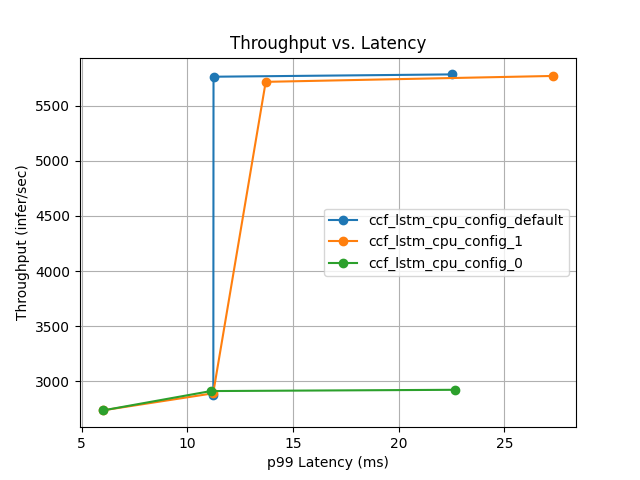

### Cpu Mem V Latency.Png

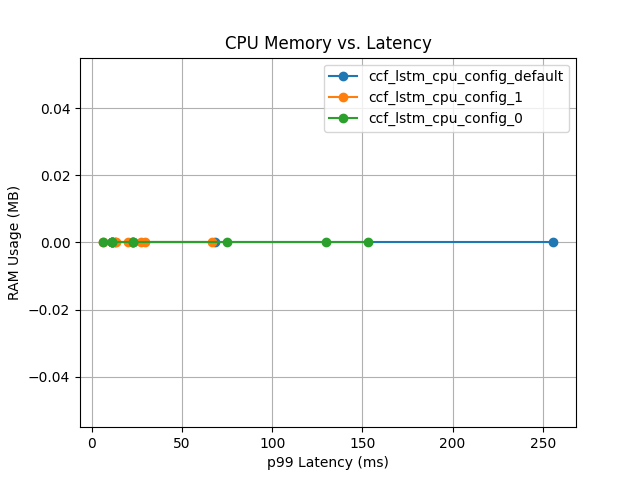

### Sample Model Config (`config.pbtxt`)

name: "ccf_lstm_cpu"
version_policy {
  latest {
    num_versions: 1
  }
}
max_batch_size: 32
input {
  name: "input_features"
  data_type: TYPE_FP32
  dims: 7
  dims: 220
}
output {
  name: "is_fraud"
  data_type: TYPE_FP32
  dims: 1
}
instance_group {
  count: 1
  kind: KIND_CPU
}
dynamic_batching {
  max_queue_delay_microseconds: 200
}
optimization {
  input_pinned_memory {
    enable: true
  }
  output_pinned_memory {
    enable: true
  }
}
backend: "onnxmlir"



### Throughput V Latency.Png

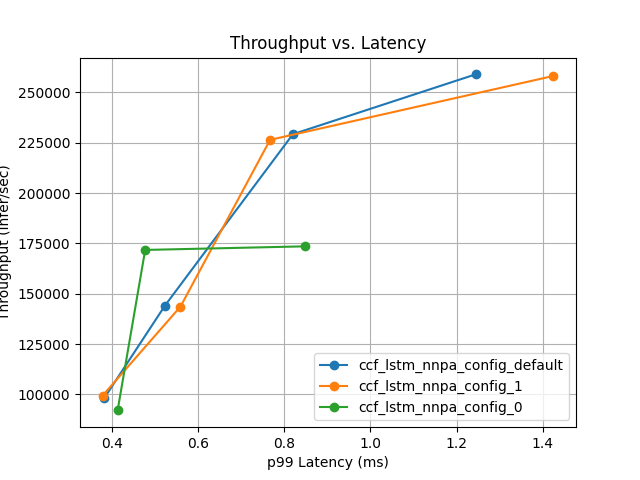

### Cpu Mem V Latency.Png

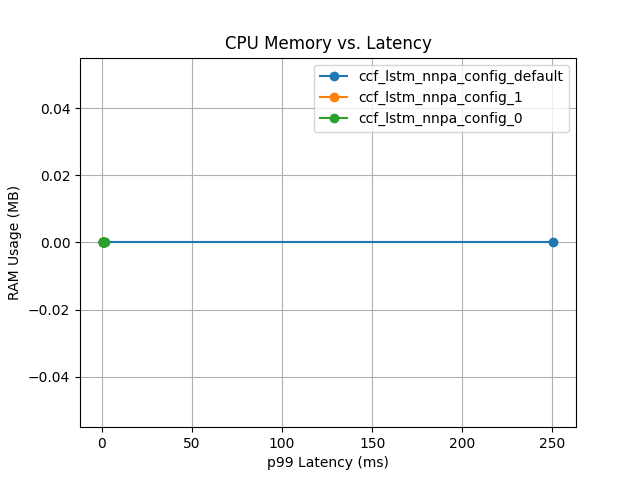

### Sample Model Config (`config.pbtxt`)

name: "ccf_lstm_nnpa"
version_policy {
  latest {
    num_versions: 1
  }
}
max_batch_size: 32
input {
  name: "input_features"
  data_type: TYPE_FP32
  dims: 7
  dims: 220
}
output {
  name: "is_fraud"
  data_type: TYPE_FP32
  dims: 1
}
instance_group {
  count: 1
  kind: KIND_CPU
}
dynamic_batching {
  max_queue_delay_microseconds: 200
}
optimization {
  input_pinned_memory {
    enable: true
  }
  output_pinned_memory {
    enable: true
  }
}
backend: "onnxmlir"



In [27]:
import pandas as pd
from IPython.display import Image, display, Markdown

# 1. Display CSV metrics
csv_path = analyzer_output_path / "reports" / "results" / "metrics-model-inference.csv"
if csv_path.exists():
    df = pd.read_csv(csv_path)
    display(Markdown("### Inference Metrics (First 10 Rows)"))
    display(df.head(10))
else:
    print("CSV metrics file not found.")


for model in [ZDLC_CPU_MODEL, ZDLC_NNPA_MODEL]:
    # 2. Display plots (throughput and CPU mem)
    plot_dir = analyzer_output_path / "reports" / "plots" / "simple" / model
    plot_files = ["throughput_v_latency.png", "cpu_mem_v_latency.png"]
    
    for plot_file in plot_files:
        plot_path = plot_dir / plot_file
        if plot_path.exists():
            display(Markdown(f"### {plot_file.replace('_', ' ').title()}"))
            display(Image(filename=str(plot_path)))
        else:
            print(f"Plot not found: {plot_file}")

    # 3. Show one config.pbtxt for context
    config_path = analyzer_output_path / "results" / f"{model}_config_0" / "config.pbtxt"
    if config_path.exists():
        display(Markdown("### Sample Model Config (`config.pbtxt`)"))
        with open(config_path) as f:
            print(f.read())
    else:
        print("Config file not found.")

#### Stop and Remove Triton Inference Server Container:

In [28]:
# Stop and remove the Triton container
!docker stop tritonserver
!docker rm tritonserver

tritonserver


tritonserver


#### Remove Custom Docker Network:

In [29]:
# List networks to verify the one to remove
!docker network ls

# Remove the custom network
!docker network rm triton-net

NETWORK ID     NAME         DRIVER    SCOPE
da031f485e82   bridge       bridge    local
60d068d57086   host         host      local
fe77e62b2bf3   none         null      local
b2b665d55a31   triton-net   bridge    local


triton-net


## Conclusion 

In this notebook, we demonstrated the complete workflow for compiling an RNN-based credit card fraud detection model using **IBM Z Deep Learning Compiler Container Images**, and deploying it with **IBM Z Accelerated for NVIDIA Triton™ Inference Server** using the `onnxmlir` backend. We walked through each configuration step in detail to ensure a smooth and reproducible deployment process.

Comprehensive testing and performance validation were carried out for both CPU and NNPA-compiled versions of the model. The results highlight a significant reduction in inference latency when utilizing the IBM Integrated Accelerator for AI (NNPA), showcasing the backend’s ability to deliver production-ready performance and efficiency.

To further quantify model performance, we leveraged the Triton Model Analyzer in a separate container to remotely profile the deployed model. This included evaluating various batch sizes, concurrency levels, and capturing latency, throughput, and CPU memory usage. The Model Analyzer provided a rich set of metrics and visual reports (including HTML summaries and plots), enabling deeper insight into model behavior under load.

This deployment approach not only optimizes runtime but also ensures scalability, observability, and hardware-level acceleration for real-time AI applications on IBM Z. With the addition of the Model Analyzer, the solution supports robust performance tuning and monitoring workflows critical for production environments.